# Likelihood-Free Inference - Amortized SNPE-C

---
The parameter sets consist of:
- **the mass of the dynamical ejecta Mej,dyn**
- **the mass of the post-merger ejecta Mej,pm**
- **the half-opening angle of the lanthanide-rich tidal dynamical ejecta Φ**
- **the cosine of the observer viewing angle cos θobs.**

---

In [1]:
import os, sys
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '6'
from torch import nn
import kilonovanet
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from tqdm.notebook import tqdm
from scipy import stats as st
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference import prepare_for_sbi, simulate_for_sbi, SNLE, ratio_estimator_based_potential, SNRE_A,SNRE,SNPE
from sbi.inference import likelihood_estimator_based_potential, ImportanceSamplingPosterior, MCMCPosterior
import torch
from scipy.stats import binned_statistic, linregress, gaussian_kde
import pandas as pd
from sbi.utils.get_nn_models import posterior_nn
import pickle
import math
import random
import scipy

# A) Functions : 

In [2]:
def flux_smoothed(arr, sigma):
    '''
    - Units: 
    
    '''
    pc_to_cm = 3.086e18
    flux_real = arr*(1/(4*math.pi*(10*3.086e18)**2))
    smooth = gaussian_filter(flux_real, sigma, 0)
    return smooth

def simulate_spec(params):
    '''Simulator that takes as input the Dietrich based simulator parameters and
    Returns a Kilonova spectra ranging from 5000A to 8000A
    
    - Smoothing on the Kilonova raw spectra to reduce the noise coming from the kilonovanet simulator
    
    - Added a Gaussian noise
    
    - Adding a noise from the real spectra --> noise_kn = (spectra - smooth(spectra))
    
    '''
    wl = np.linspace(100.0, 99900, 500)
    time = [1.5,2.5,3.5]
    spec = model.predict_spectra(params,time)
    smoothed_flux0 = flux_smoothed(spec[0][0], 2.0)
    smoothed_flux1 = flux_smoothed(spec[0][1], 2.0)
    smoothed_flux2 = flux_smoothed(spec[0][2], 2.0)

    smoothed_sed0 = np.vstack([wl, smoothed_flux0]).T
    flux_interp0 = np.interp(wl_sim, smoothed_sed0[:,0], smoothed_sed0[:,1])
    
    smoothed_sed1 = np.vstack([wl, smoothed_flux1]).T
    flux_interp1 = np.interp(wl_sim, smoothed_sed1[:,0], smoothed_sed1[:,1])
    
    smoothed_sed2 = np.vstack([wl, smoothed_flux2]).T
    flux_interp2 = np.interp(wl_sim, smoothed_sed2[:,0], smoothed_sed2[:,1])
    
    flux_interp = np.concatenate((flux_interp0.reshape((550,1)),flux_interp1.reshape((550,1)),flux_interp2.reshape((550,1))),axis=-1)
    #applying the noise:
    idx_noise = [5,6,4,2,1,0,7]
    for i in range(len(flux_interp)):
        for j in range(flux_interp.shape[-1]):
            noise_std = (5/100)*flux_interp[i,j]
            error = np.random.normal(0, noise_std, 1)
            error2idx = random.choice(idx_noise)
            flux_interp[i,j] = flux_interp[i,j] + error + 0*(knreal2[error2idx,:,1] -scipy.ndimage.uniform_filter1d(knreal2[error2idx,:,1],100))[i]
    
    return flux_interp
def simulate_spec_noiseless(params):
    '''Simulator that takes as input the Dietrich based simulator parameters and
    Returns a Kilonova spectra ranging from 5000A to 8000A
    
    - Smoothing on the Kilonova raw spectra to reduce the noise coming from the kilonovanet simulator
    
    - Added a Gaussian noise
    
    - Adding a noise from the real spectra --> noise_kn = (spectra - smooth(spectra))
    
    '''
    wl = np.linspace(100.0, 99900, 500)
    time = [1.5,2.5,3.5]
    spec = model.predict_spectra(params,time)
    smoothed_flux0 = flux_smoothed(spec[0][0], 2.0)
    smoothed_flux1 = flux_smoothed(spec[0][1], 2.0)
    smoothed_flux2 = flux_smoothed(spec[0][2], 2.0)

    smoothed_sed0 = np.vstack([wl, smoothed_flux0]).T
    flux_interp0 = np.interp(wl_sim, smoothed_sed0[:,0], smoothed_sed0[:,1])
    
    smoothed_sed1 = np.vstack([wl, smoothed_flux1]).T
    flux_interp1 = np.interp(wl_sim, smoothed_sed1[:,0], smoothed_sed1[:,1])
    
    smoothed_sed2 = np.vstack([wl, smoothed_flux2]).T
    flux_interp2 = np.interp(wl_sim, smoothed_sed2[:,0], smoothed_sed2[:,1])
    
    flux_interp = np.concatenate((flux_interp0.reshape((550,1)),flux_interp1.reshape((550,1)),flux_interp2.reshape((550,1))),axis=-1)
    #applying the noise:
    idx_noise = [5,6,4,2,1,0,7]
    for i in range(len(flux_interp)):
        for j in range(flux_interp.shape[-1]):
            noise_std = (5/100)*flux_interp[i,j]
            error = np.random.normal(0, noise_std, 1)
            error2idx = random.choice(idx_noise)
            flux_interp[i,j] = flux_interp[i,j] + error*0 + 0*(knreal2[error2idx,:,1] -scipy.ndimage.uniform_filter1d(knreal2[error2idx,:,1],100))[i]
    
    return flux_interp

def simulate_spec_neuroips(params):
    wl = np.linspace(100.0, 99900, 500)
    time = [0.5,1.5,2.5,3.5,4.5]
    spec = model.predict_spectra(params,time)
    smoothed_flux0 = flux_smoothed(spec[0][0], 2.0)
    smoothed_flux1 = flux_smoothed(spec[0][1], 2.0)
    smoothed_flux2 = flux_smoothed(spec[0][2], 2.0)
    smoothed_flux3 = flux_smoothed(spec[0][3], 2.0)
    smoothed_flux4 = flux_smoothed(spec[0][4], 2.0)    
    smoothed_sed0 = np.vstack([wl, smoothed_flux0]).T
    flux_interp0 = np.interp(wl_sim, smoothed_sed0[:,0], smoothed_sed0[:,1])
    
    smoothed_sed1 = np.vstack([wl, smoothed_flux1]).T
    flux_interp1 = np.interp(wl_sim, smoothed_sed1[:,0], smoothed_sed1[:,1])
    
    smoothed_sed2 = np.vstack([wl, smoothed_flux2]).T
    flux_interp2 = np.interp(wl_sim, smoothed_sed2[:,0], smoothed_sed2[:,1])
    
    smoothed_sed3 = np.vstack([wl, smoothed_flux3]).T
    flux_interp3 = np.interp(wl_sim, smoothed_sed3[:,0], smoothed_sed3[:,1])
    
    smoothed_sed4 = np.vstack([wl, smoothed_flux4]).T
    flux_interp4 = np.interp(wl_sim, smoothed_sed4[:,0], smoothed_sed4[:,1])
        
    flux_interp = np.concatenate((flux_interp0.reshape((550,1)),flux_interp1.reshape((550,1)),flux_interp2.reshape((550,1)),flux_interp3.reshape((550,1)),flux_interp4.reshape((550,1))),axis=-1)
    return flux_interp


In [4]:
def sample_ensemble(kncomba):
    n_samples = 5000
    a  = ["Mdyn",'Mpm',r"$\phi$",r"$cos(\theta)$"]
    #dados10Tdock2/phelipedata/Kilonova_Simulation_Based_Inference/Notebooks/SCRIPTS/KFOLD/model_nonorm_fold_3_nsf_noise_5.pkl
    path = '/tf/dados10Tdock2/phelipedata/Kilonova_Simulation_Based_Inference/Notebooks/SCRIPTS/DEEPensemble/'
    modelos = [path+"knnoise_1.0_model_stdFalse_deepensemble_0_mdn_noise_10.pkl",path+"knnoise_1.0_model_stdFalse_deepensemble_1_mdn_noise_10.pkl",
               path+"knnoise_1.0_model_stdFalse_deepensemble_2_mdn_noise_10.pkl",path+"knnoise_1.0_model_stdFalse_deepensemble_3_mdn_noise_10.pkl",
               path+"knnoise_1.0_model_stdFalse_deepensemble_4_mdn_noise_10.pkl"]
    posterior_total = np.zeros((len(kncomba),n_samples*len(modelos),4))
    for j in range(len(kncomba)):
        posterior_folds=[]
        for p in range(len(modelos)):
            with open(modelos[p], "rb") as z:
                hatp_x_y = pickle.load(z)
            wl_sim = np.linspace(5000.0, 8000.0, 550)
            posterior_samples = hatp_x_y.sample((n_samples,),x = torch.as_tensor(kncomba[j:j+1].astype(float)).to('cuda'),show_progress_bars=False).cpu().numpy()
            #print(posterior_samples.shape)
            posterior_folds.extend(posterior_samples)
        posterior_folds =np.array(posterior_folds)
        #print(posterior_folds.shape , '(25000,4)')
        posterior_total[j,:,0] = posterior_folds[:,0]
        posterior_total[j,:,1] = posterior_folds[:,1]
        posterior_total[j,:,2] = posterior_folds[:,2]
        posterior_total[j,:,3] = posterior_folds[:,3]
    return posterior_total

In [192]:
def sampling_testset(X_test1 ,hatp_x_y1, y_test1 ):
    posterior_dist=[]
    thetas = []
    for j in range(len(X_test1[:1000])):
        maxtheta = []
        samples = hatp_x_y1.sample((1500,),x = torch.as_tensor(X_test1[j:j+1]).to('cuda'),show_progress_bars=False).cpu().numpy()
        #support = [np.linspace(1e-2,9e-2, 100),np.linspace(1e-2,0.09, 100),np.linspace(0,1, 100)]
        posterior_dist.append(samples)
        
        support = [np.linspace(0,0.02, 100),np.linspace(0.01,0.13, 100),np.linspace(0,90, 100),np.linspace(0,1, 100)]
        for i in range(4):
            kdec = gaussian_kde(samples[:,i])
            #Samplando os valores dentro da gaussian
            yc = kdec(support[i])
            #pegando o valor mais provavel
            maxtheta.append(support[i][np.argmax(yc)])
            #maxcos = support[np.argmax(yc)]
        thetas.append(maxtheta)
    maxtheta = np.array(maxtheta)
    y_testframe = pd.DataFrame(y_test1,columns=["Mdyn",'Mpm', r"$\phi$",r"$cos(\theta$)"])
    thetas = pd.DataFrame(thetas,columns=["Mdyn",'Mpm', r"$\phi$",r"$cos(\theta$)"])
    return maxtheta, y_testframe,thetas , np.array(posterior_dist)

# 1) Simulate for SBI

In [4]:
X_datakn = np.load('/tf/dados10Tdock2/phelipedata/KilonovasDataset/KNpreprocessednoise2.npy',allow_pickle=True)
metadata = '/tf/dados10Tdock2/phelipedata/Kilonovas-spec/Pytorch_notebooks/data_kilonovanet/metadata_bulla_bns.json'
model_file = '/tf/dados10Tdock2/phelipedata/Kilonovas-spec/Pytorch_notebooks/data_kilonovanet/bulla-bns-latent-20-hidden-1000-CV-4-2021-04-21-epoch-200.pt'
model = kilonovanet.Model(metadata, model_file)
knreal2 =np.load('/tf/dados10Tdock2/phelipedata/KilonovasDataset/Charlespaper_KNrealpreprocessed_nonorm.npy',allow_pickle=True)

In [5]:
#prior para simulação 
prior = utils.BoxUniform(low = torch.tensor([1e-3, 1e-2, 0.0, 0.0]), 
                         high = torch.tensor([2e-2, 0.13, 90, 1.0]))
#prio para treino
prior_cuda = utils.BoxUniform(low = torch.tensor([1e-3, 1e-2, 0.0, 0.0]), 
                         high = torch.tensor([2e-2, 0.13, 90, 1.0]), device='cuda')
#range do espectro de entrada
wl_sim = np.linspace(5000.0, 8000.0, 550)

/opt/conda/lib/python3.8/site-packages/sbi/utils/torchutils.py:27: UserWarning: GPU was selected as a device for training the neural network. Note that we expect **no** significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  warnings.warn(


In [7]:
simulator, prior = prepare_for_sbi(simulate_spec, prior)

In [146]:
theta, X_datakilonet = simulate_for_sbi(simulator, proposal=prior, num_simulations=1000 ,num_workers=1)

Running 1000 simulations.:   0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [157]:
X_datakilonet = np.load(f"/tf/dados10Tdock2/phelipedata/Kilonova_Simulation_Based_Inference/Notebooks/SCRIPTS/DEEPensemble/X_data_noise_10_realgwnoise_0.0_numsamples_100000.npy")
theta = np.load(f"/tf/dados10Tdock2/phelipedata/Kilonova_Simulation_Based_Inference/Notebooks/SCRIPTS/DEEPensemble/y_data_noise_10_realgwnoise_0.0_numsamples_100000.npy")
# X_datakilonet = np.array(X_datakilonet).astype(float)
# X_datakilonetnonorm = np.copy(X_datakilonet)

In [158]:
X_datakilonet[0,:,2].max()

0.00047834397992119193

In [11]:
X_datakilonet = np.array(X_datakilonet).astype(float)
for i in range(len(X_datakilonet)):
    for j in range(3):
        mean= np.mean(X_datakilonet[i][:,j])
        std = np.std(X_datakilonet[i][:,j])
        X_datakilonet[i][:,j] = (X_datakilonet[i][:,j]-mean)/abs(std)

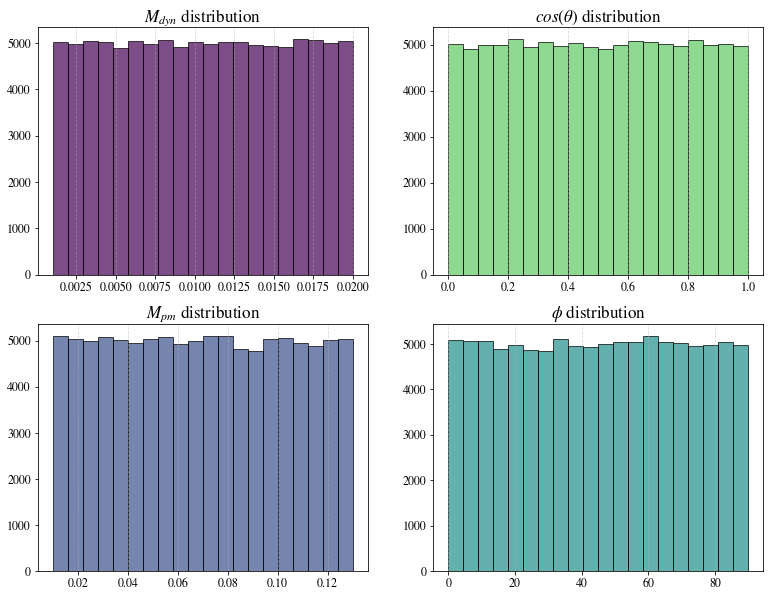

In [159]:
# Create a figure and a grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(13, 10))
# Plot data in each subplot
axs[0,0].hist(theta[:,0],bins=20, color='#440154', edgecolor='black', alpha=0.7,histtype='barstacked')
axs[0,0].set_title('$M_{dyn}$ distribution', fontsize=17)

axs[1,0].hist(theta[:,1],bins=20, color='#3b528b',edgecolor='black', alpha=0.7,histtype='barstacked')
axs[1,0].set_title('$M_{pm}$ distribution', fontsize=17)

axs[1,1].hist(theta[:,2],bins=20, color='#21918c',edgecolor='black', alpha=0.7,histtype='barstacked')
axs[1,1].set_title(r"$\phi$" +' distribution', fontsize=17)

axs[0,1].hist(theta[:,3],bins=20, color='#5ec962',edgecolor='black', alpha=0.7,histtype='barstacked')
axs[0,1].set_title(r"$cos(\theta)$" +' distribution', fontsize=17)

for ax in axs.flatten():
    ax.grid(True,ls='--',alpha=0.5, axis='x')
#plt.grid(axis='y', linestyle='--', alpha=0.5)
#plt.grid()
#plt.savefig('testehist', dpi=300, bbox_inches='tight')
plt.show()


# 2) Training

---

In [160]:
#Embaralhando o dataset:
theta = np.array(theta).astype(float)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_datakilonet, theta, test_size=0.05, random_state=50)
X_train = np.swapaxes(X_train[:,:,:],1,2)
X_test = np.swapaxes(X_test[:,:,:],1,2)
print(X_train[0][0].max(),X_train[0][0].min())
print(X_train.shape)

0.012761535122990608 0.004703204613178968
(95000, 3, 550)


In [126]:
class Model5(nn.Module):
    def __init__(self,filters1,filters2,filters3,ks1,ks2,ks3,lstm1,lstm2,outfeat):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=3, out_channels=filters1, kernel_size=2,padding='same')
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=ks1, stride=ks1)
        #divide por 2
        self.conv2 = nn.Conv1d(in_channels=filters1, out_channels=filters2, kernel_size=2,padding='same')
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(kernel_size=ks2, stride=ks2)
        #divide por 3
        self.conv3 = nn.Conv1d(in_channels=filters2, out_channels=filters3, kernel_size=2,padding='same')
        self.act3 = nn.ReLU()
        self.pool3 = nn.MaxPool1d(kernel_size=ks3, stride=ks3)
        #divide por 2
        #550/2*2*3
        self.lstm = nn.LSTM(input_size=filters3, hidden_size=lstm1, bidirectional=True, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=lstm1*2, hidden_size=lstm2, bidirectional=True, batch_first=True)
        # in features do fc1 = 550/2*3*2 )* 256*2
        # 68
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(in_features=int((lstm2*2)*(int((550)/(ks1*ks2*ks3)))), out_features=outfeat)
        self.act4 = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        #x = self.dropout1(x)
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.act3(x)
        x = self.pool3(x)
        x = torch.permute(x, (0,2,1)) 
        x, _ = self.lstm(x)
        x, _ = self.lstm2(x)
        x = self.flat(x)
        x = self.fc1(x)
        x = self.act4(x)
        return x

In [127]:
# Model 5 parameters
embbeding_filters1=128
embbeding_filters2=128
embbeding_filters3=64
embbeding_ks1= 2
embbeding_ks2= 2
embbeding_ks3= 3
embbeding_lstm1= 300
embbeding_lstm2= 300
embbeding_outfeat = 100

In [128]:
embed_net = Model5(embbeding_filters1,embbeding_filters2,embbeding_filters3,embbeding_ks1,embbeding_ks2,embbeding_ks3,embbeding_lstm1,embbeding_lstm2,embbeding_outfeat)
#------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
density_estimator_build_fn = posterior_nn(model='mdn',embedding_net=embed_net,num_bins=10 ,num_transforms=4,hidden_features=5)
#------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
anpe =SNPE(prior=prior_cuda, density_estimator=density_estimator_build_fn,device='cuda')
#------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#num_bins=50, num_transforms =50, hidden_features=100,density_estimator_kwargs={'temperature': 1.6}
#------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
anpe.append_simulations(
    torch.as_tensor(y_train.astype(np.float32)).to('cuda'),
    torch.as_tensor(X_train.astype(np.float32)).to('cuda'))
#------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
p_x_y_estimator = anpe.train(training_batch_size=1024,stop_after_epochs=40, max_num_epochs=1000,use_combined_loss=False,show_train_summary=True,retrain_from_scratch=True,force_first_round_loss=True)

/opt/conda/lib/python3.8/site-packages/sbi/utils/torchutils.py:27: UserWarning: GPU was selected as a device for training the neural network. Note that we expect **no** significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  warnings.warn(


 Neural network successfully converged after 314 epochs.
        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 314
        Best validation performance: 9.5179
        -------------------------
        


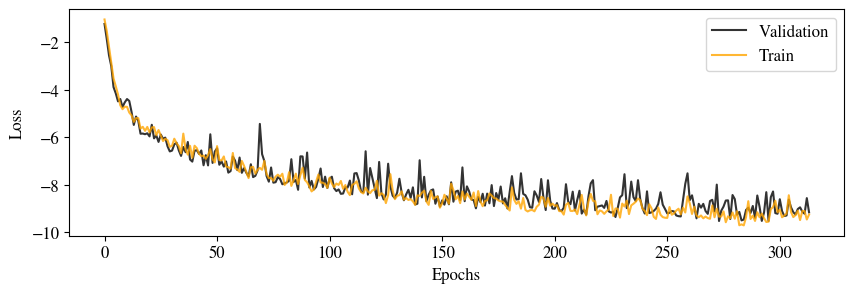

In [141]:
plt.figure(dpi=100,figsize=(10,3))
plt.plot(np.array(anpe._summary['validation_log_probs'])*-1, label='Validation', color='black',alpha=0.8)
plt.plot(np.array(anpe._summary['training_log_probs'])*-1, label='Train', color='orange',alpha=0.8)
#plt.title('SBI')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
#plt.savefig('/tf/dados10Tdock2/phelipedata/KNfits/Notebooks/Dietrich_Models/Figures_NeuroIPS/Model_Gaussian_error_plot/0Loss_epoch_nsf',dpi=300,bbox_inches = 'tight')
plt.show()

In [131]:
hatp_x_y = anpe.build_posterior(p_x_y_estimator)
# with open("/tf/dados10Tdock2/phelipedata/Kilonova_Simulation_Based_Inference/Notebooks/SCRIPTS/KFOLD/model_nonorm_fold_0_mdn_noise_5.pkl", "rb") as z:
#     hatp_x_y = pickle.load(z)

/opt/conda/lib/python3.8/site-packages/sbi/utils/torchutils.py:27: UserWarning: GPU was selected as a device for training the neural network. Note that we expect **no** significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  warnings.warn(


In [132]:
X_test.shape

(5000, 3, 550)

# 3) Testing on the Simulated Data:

In [20]:
##save modeldados10Tdock2/phelipedata/KN_fits_models
# with open("/tf/dados10Tdock2/phelipedata/KN_fits_models/modeloagosto/teste.pkl", "wb") as handle:
#     pickle.dump(hatp_x_y, handle)

In [21]:
##open
# with open("/tf/dados10Tdock2/phelipedata/KN_fits_models/modeloagosto/errorgauss_nosmooth_mdn_152535_dietrich-Copy1.pkl", "rb") as z:
#     hatp_x_y = pickle.load(z)

In [133]:
maxtheta, y_testframe,thetas, posterior_dist = sampling_testset(X_test,hatp_x_y, y_test)

/opt/conda/lib/python3.8/site-packages/torch/nn/modules/rnn.py:761: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/aten/src/ATen/native/cudnn/RNN.cpp:926.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


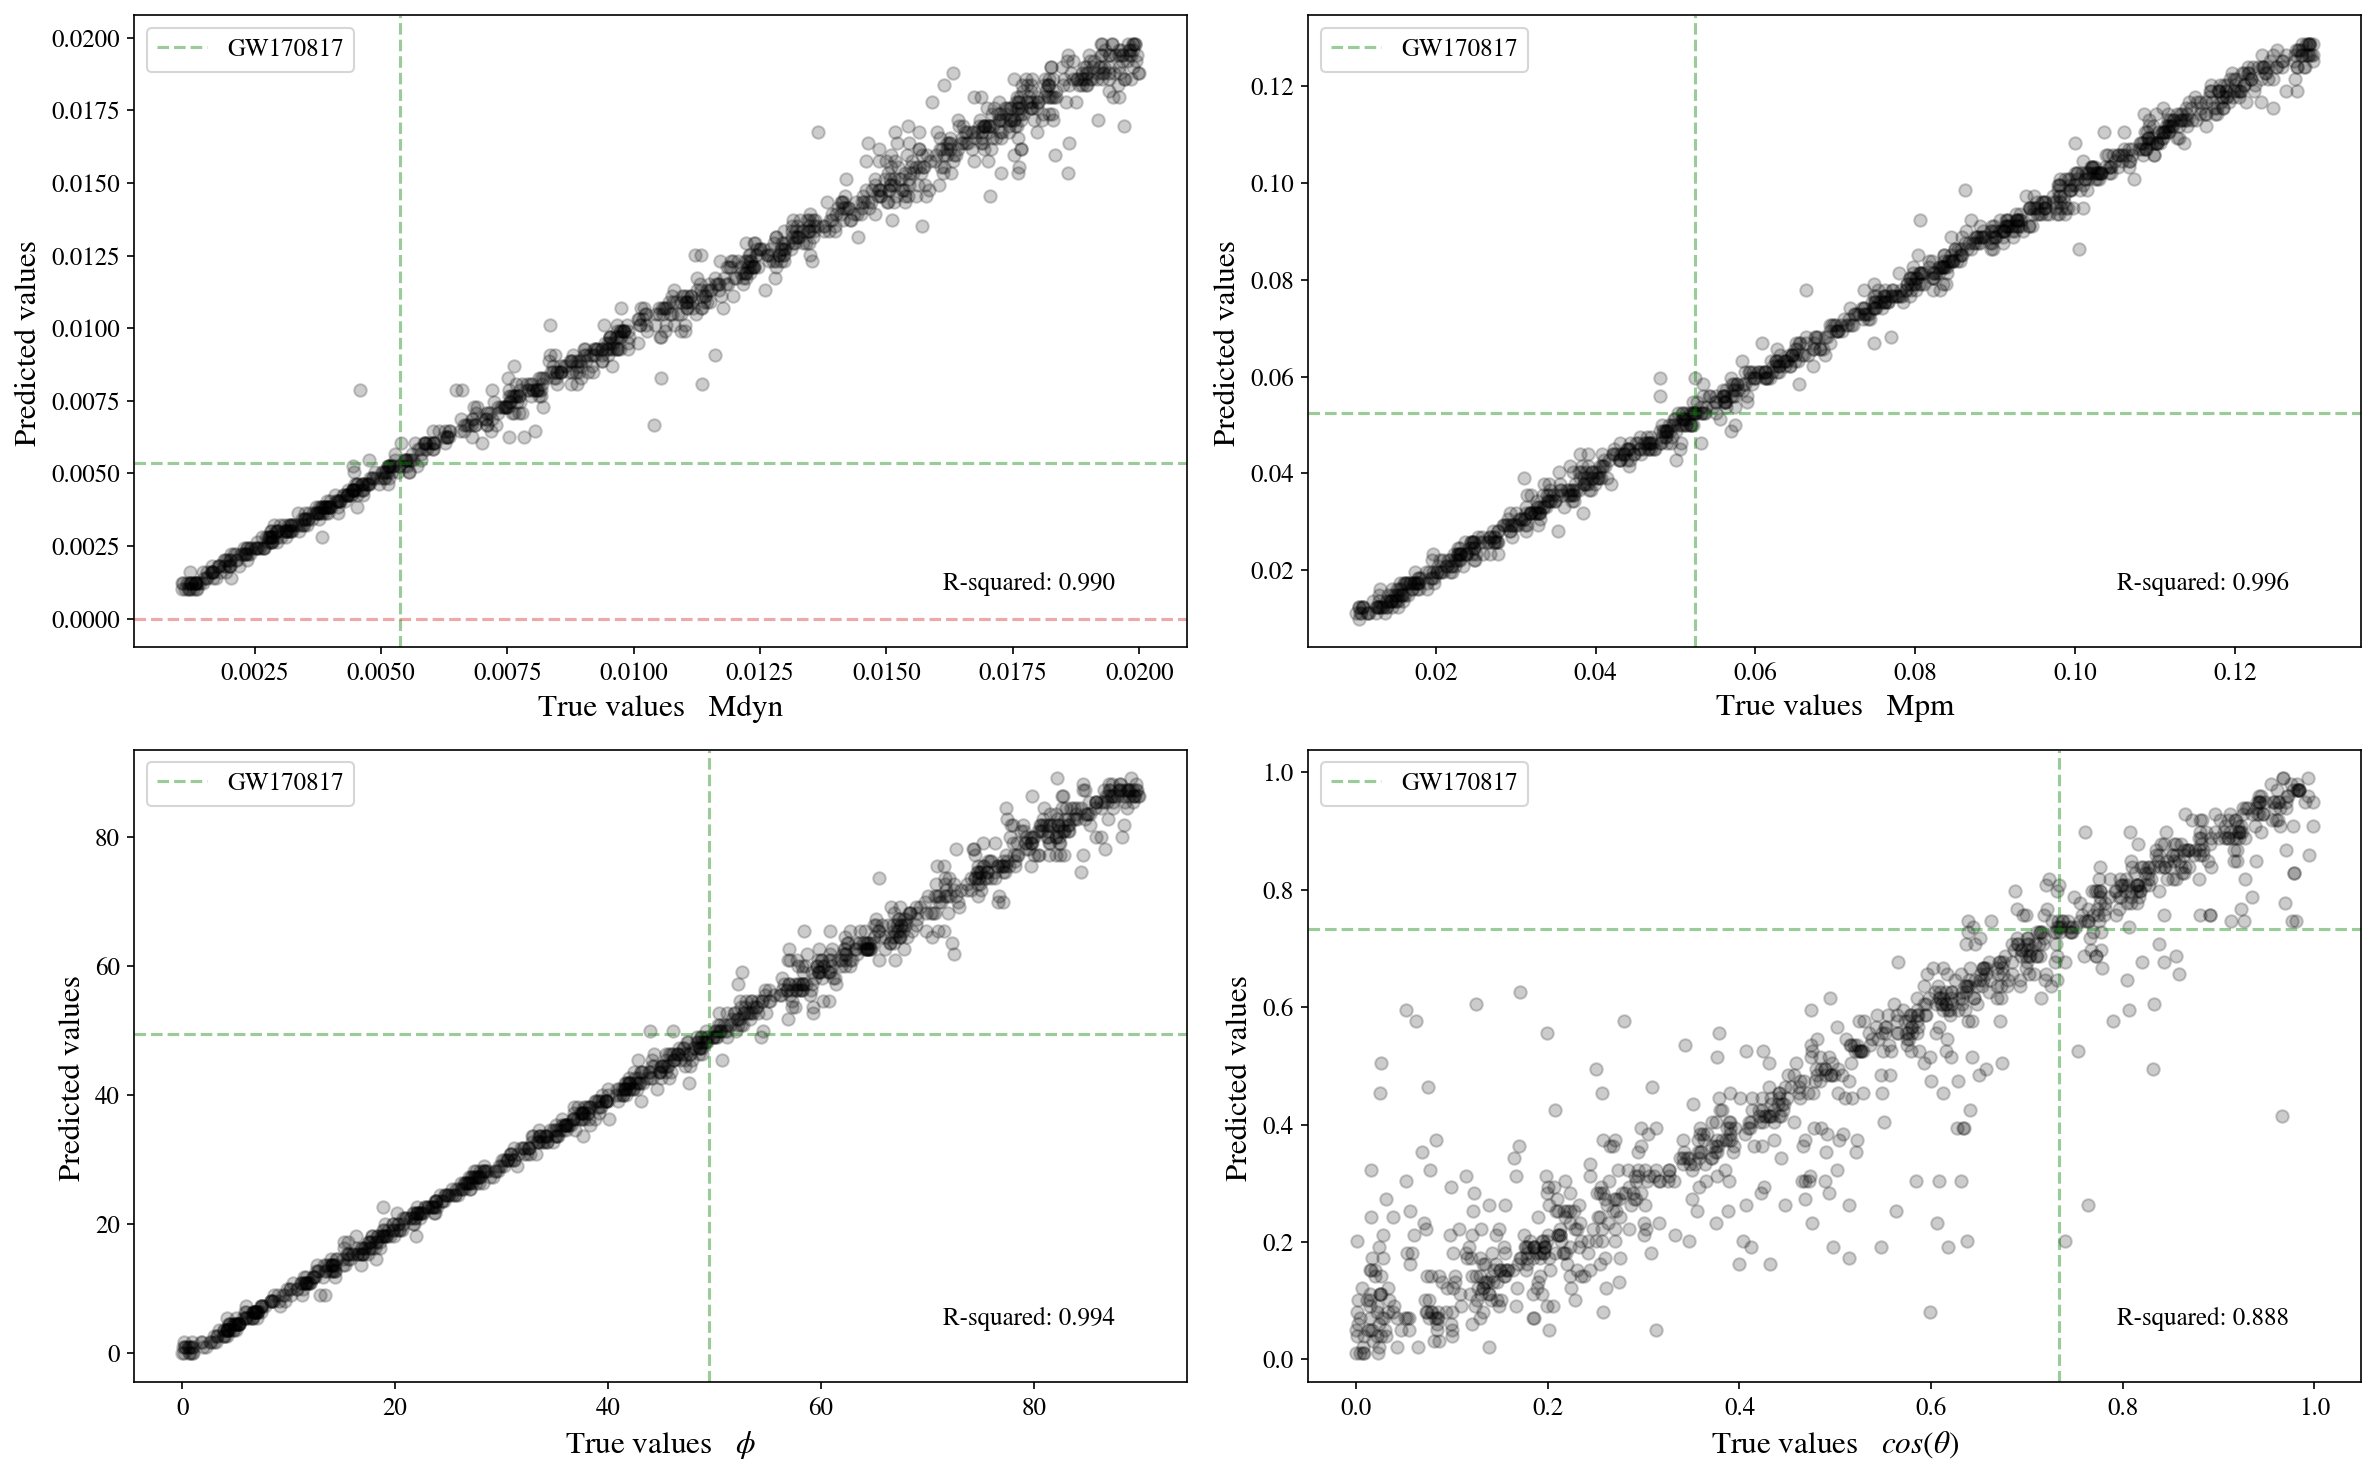

In [20]:
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, explained_variance_score
Gw_dietrich = [0.005370317963702527, 0.05248074602497726, 49.5, 0.7337298645028765]

a  = ["Mdyn",'Mpm', r"$\phi$",r"$cos(\theta$)"]

plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams.update({'font.size': 12})


true_values = y_testframe[a[0]][:1000]
predicted_values = thetas[a[0]][:1000]

true_values1 = y_testframe[a[1]][:1000]
predicted_values1 = thetas[a[1]][:1000]

true_values2 = y_testframe[a[2]][:1000]
predicted_values2 = thetas[a[2]][:1000]

true_values3 = y_testframe[a[3]][:1000]
predicted_values3 = thetas[a[3]][:1000]
r2 = r2_score(true_values, predicted_values)
r21 = r2_score(true_values1, predicted_values1)
r22 = r2_score(true_values2, predicted_values2)
r23 = r2_score(true_values3, predicted_values3)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 10),dpi=150)


# Plot scatter plot of predicted vs true values
# residuals = np.array(true_values - predicted_values)
# axes[0,0].scatter(true_values, residuals , color='red', alpha=0.2)
axes[0,0].axhline(y=0, color='C3', linestyle='--', alpha=0.4)
#linha do mean residual:
axes[0,0].scatter(true_values, predicted_values , color='black', alpha=0.2)
axes[0,0].set_xlabel('True values   '+a[0],fontsize=15)
axes[0,0].set_ylabel('Predicted values   ',fontsize=15)
axes[0,0].axhline(y=Gw_dietrich[0], color='g', linestyle='--', label='GW170817', alpha=0.4)
axes[0,0].axvline(x=Gw_dietrich[0], color='g', linestyle='--', alpha=0.4)
 


axes[0,0].text(0.85, 0.1,  f"R-squared: {r2:.3f}", horizontalalignment='center',verticalalignment='center', transform=axes[0,0].transAxes,fontsize=12)

axes[0,0].legend()

# Plot scatter plot of predicted vs true values
axes[0,1].scatter(true_values1, predicted_values1 , color='black', alpha=0.2)
axes[0,1].set_xlabel('True values   '+a[1],fontsize=15)
axes[0,1].set_ylabel('Predicted values   ',fontsize=15)
axes[0,1].axhline(y=Gw_dietrich[1], color='g', linestyle='--', label='GW170817', alpha=0.4)
axes[0,1].axvline(x=Gw_dietrich[1], color='g', linestyle='--', alpha=0.4)
#axes[0].set_title(a[i]+' Scatter plot of predicted vs true values',fontsize=20)
axes[0,1].text(0.85, 0.1,  f"R-squared: {r21:.3f}", horizontalalignment='center',verticalalignment='center', transform=axes[0,1].transAxes,fontsize=12)
axes[0,1].legend()


# Plot scatter plot of predicted vs true values
axes[1,0].scatter(true_values2, predicted_values2 , color='black', alpha=0.2)
axes[1,0].set_xlabel('True values   '+a[2],fontsize=15)
axes[1,0].set_ylabel('Predicted values   ',fontsize=15)
axes[1,0].axhline(y=Gw_dietrich[2], color='g', linestyle='--', label='GW170817', alpha=0.4)
axes[1,0].axvline(x=Gw_dietrich[2], color='g', linestyle='--', alpha=0.4)
#axes[0].set_title(a[i]+' Scatter plot of predicted vs true values',fontsize=20)
axes[1,0].text(0.85, 0.1,  f"R-squared: {r22:.3f}", horizontalalignment='center',verticalalignment='center', transform=axes[1,0].transAxes,fontsize=12)
axes[1,0].legend()



# Plot scatter plot of predicted vs true values
axes[1,1].scatter(true_values3, predicted_values3 , color='black', alpha=0.2)

axes[1,1].set_xlabel('True values   '+a[3],fontsize=15)
axes[1,1].set_ylabel('Predicted values   ',fontsize=15)
axes[1,1].axhline(y=Gw_dietrich[3], color='g', linestyle='--', label='GW170817', alpha=0.4)
axes[1,1].axvline(x=Gw_dietrich[3], color='g', linestyle='--', alpha=0.4)
#axes[0].set_title(a[i]+' Scatter plot of predicted vs true values',fontsize=20)
axes[1,1].text(0.85, 0.1,  f"R-squared: {r23:.3f}", horizontalalignment='center',verticalalignment='center', transform=axes[1,1].transAxes,fontsize=12)
axes[1,1].legend()

plt.tight_layout()
    #plt.savefig('/tf/dados10Tdock2/phelipedata/KNfits/Notebooks/Dietrich_Models/Figures_NeuroIPS/Model_Gaussian_error_plot/Simulated_performance_'+str(a[i]),dpi=300,bbox_inches = 'tight')
    
    
#plt.savefig('parameters_plot',dpi=200,bbox_inches='tight')
    # Show the plot
plt.show()

# Kolmogorov-Smirnov (KS) TEST

In [190]:
def KS_test(y_teste,posterior_dist,bins_plot,plot_hist=False):
    
    '''
    KS test was developed to compare two distributions and output a score representing how close the both distributions are.
    In order to acess the performance of our model we are going to compare the True values distributions with a random samples values from the posterior of each spectra generated
    using the True Values.

    summary: For each true values of (Mdy..) --- > X_test and our model will generate the pr
    '''
    import numpy as np
    from scipy.stats import ks_2samp ,ks_1samp
    import scipy.stats as stats
    import matplotlib.pyplot as plt
    label_parameter = ["Mdyn",'Mpm', r"$\phi$",r"$cos(\theta$)"]
    parameter0 = []
    parameter1 = [] 
    parameter2 = []
    parameter3 = []
    for i in range(len(posterior_dist)):
        parameter0.append(random.choice(posterior_dist[i,:,0]))
        parameter1.append(random.choice(posterior_dist[i,:,1]))
        parameter2.append(random.choice(posterior_dist[i,:,2]))
        parameter3.append(random.choice(posterior_dist[i,:,3]))
    parameter0 = np.array(parameter0).astype(float)
    parameter1 = np.array(parameter1).astype(float) 
    parameter2 = np.array(parameter2).astype(float)
    parameter3 = np.array(parameter3).astype(float)
    #Compare both distribution and perform the KS test
    ks_statistic0, p_value0 = ks_2samp(parameter0, y_teste[label_parameter[0]])
    ks_statistic1, p_value1 = ks_2samp(parameter1, y_teste[label_parameter[1]])
    ks_statistic2, p_value2 = ks_2samp(parameter2, y_teste[label_parameter[2]])
    ks_statistic3, p_value3 = ks_2samp(parameter3, y_teste[label_parameter[3]])
    print(f'Parameter {label_parameter[0]} --> P-Value: {p_value0}  1D-KS score: {ks_statistic0}')
    print(f'Parameter {label_parameter[1]} --> P-Value: {p_value1}  1D-KS score: {ks_statistic1}')
    print(fr'Parameter {label_parameter[2]} --> P-Value: {p_value2}  1D-KS score: {ks_statistic2}')
    print(f'Parameter {label_parameter[3]} --> P-Value: {p_value3}  1D-KS score: {ks_statistic3}')
    if plot_hist == True:
        bins_plot = 40
        fig, axs = plt.subplots(2, 2, figsize=(13, 10))
        # Plot data in each subplot
        axs[0,0].hist(parameter0,bins=bins_plot, color=('#440154'), edgecolor='black', alpha=0.7,histtype='barstacked',density=True)
        axs[0,0].hist(y_teste[label_parameter[0]],bins=bins_plot, color='red', edgecolor='black', alpha=0.4,histtype='barstacked',density=True)

        axs[0,0].set_title('$M_{dyn}$ distribution', fontsize=17)

        axs[1,0].hist(parameter1,bins=bins_plot, color='#3b528b',edgecolor='black', alpha=0.7,histtype='barstacked',density=True)
        axs[1,0].hist(y_teste[label_parameter[1]],bins=bins_plot, color='red',edgecolor='black', alpha=0.4,histtype='barstacked',density=True)

        axs[1,0].set_title('$M_{pm}$ distribution', fontsize=17)

        axs[1,1].hist(parameter2,bins=bins_plot, color='#21918c',edgecolor='black', alpha=0.7,histtype='barstacked',density=True)
        axs[1,1].hist(y_teste[label_parameter[2]],bins=bins_plot, color='red',edgecolor='black', alpha=0.4,histtype='barstacked',density=True)

        axs[1,1].set_title(r"$\phi$" +' distribution', fontsize=17)

        axs[0,1].hist(parameter3,bins=bins_plot, color='#5ec962',edgecolor='black', alpha=0.7,histtype='step',density=True)
        axs[0,1].hist(y_teste[label_parameter[3]],bins=bins_plot, color='red',edgecolor='black', alpha=0.5,histtype='step',density=True)

        axs[0,1].set_title(r"$cos(\theta)$" +' distribution', fontsize=17)

        for ax in axs.flatten():
            ax.grid(True,ls='--',alpha=0.5, axis='x')
        #plt.grid(axis='y', linestyle='--', alpha=0.5)
        #plt.grid()
        #plt.savefig('testehist', dpi=300, bbox_inches='tight')
        plt.show()
        
    

In [194]:
posterior_dist = sample_ensemble(X_test)

                    accepted. It may take a long time to collect the remaining
                    4975 samples. Consider interrupting (Ctrl-C) and switching to
                    `build_posterior(..., sample_with='mcmc')`.


In [195]:
posterior_dist = np.array(posterior_dist)

Parameter Mdyn --> P-Value: 0.14196445001472696  1D-KS score: 0.023
Parameter Mpm --> P-Value: 0.33994536027287675  1D-KS score: 0.0188
Parameter $\phi$ --> P-Value: 0.8367973787613723  1D-KS score: 0.0124
Parameter $cos(\theta$) --> P-Value: 0.03348003156864409  1D-KS score: 0.0286


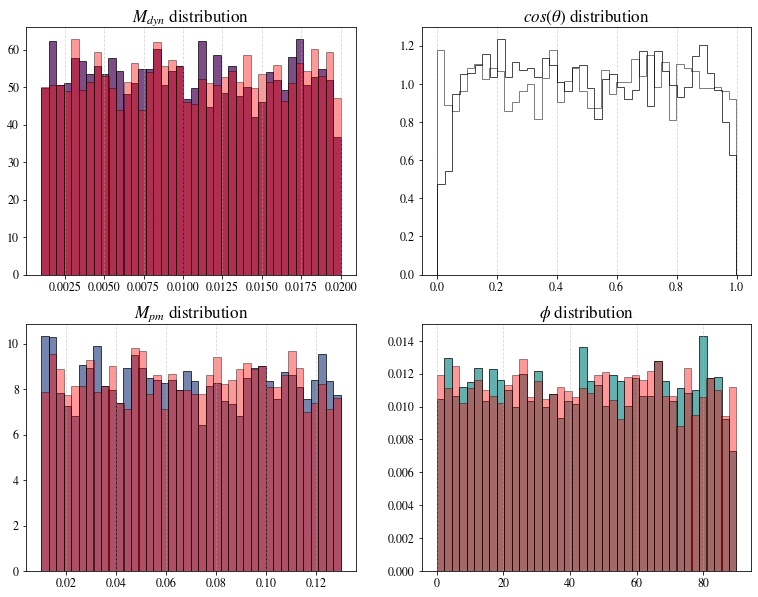

In [196]:
KS_test(y_testframe,posterior_dist,bins_plot = 30,plot_hist=True)

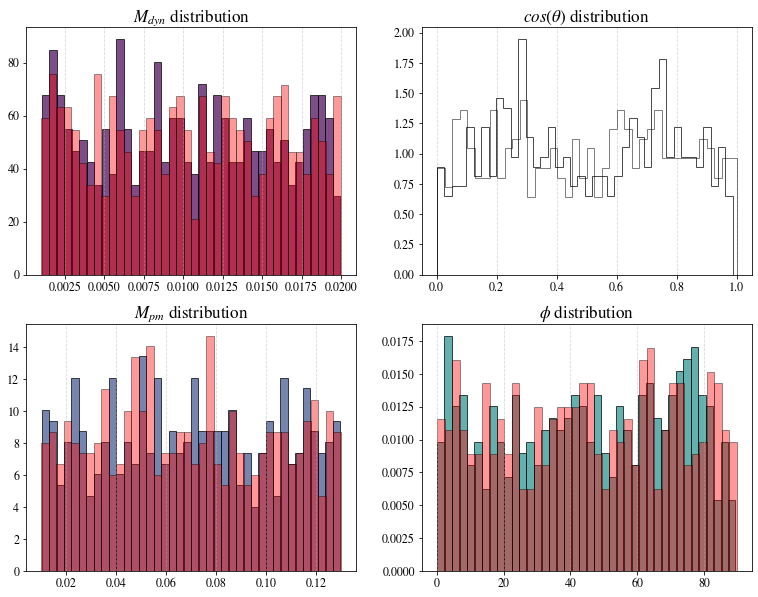

In [ ]:
bins_plot = 40
fig, axs = plt.subplots(2, 2, figsize=(13, 10))
# Plot data in each subplot
axs[0,0].hist(parameter0,binbins_plot, color=('#440154'), edgecolor='black', alpha=0.7,histtype='barstacked',density=True)
axs[0,0].hist(y_testframe[a[0]],bins=bins_plot, color='red', edgecolor='black', alpha=0.4,histtype='barstacked',density=True)

axs[0,0].set_title('$M_{dyn}$ distribution', fontsize=17)

axs[1,0].hist(parameter1,bins=bins_plot, color='#3b528b',edgecolor='black', alpha=0.7,histtype='barstacked',density=True)
axs[1,0].hist(y_testframe[a[1]],bins=bins_plot, color='red',edgecolor='black', alpha=0.4,histtype='barstacked',density=True)

axs[1,0].set_title('$M_{pm}$ distribution', fontsize=17)

axs[1,1].hist(parameter2,bins=bins_plot, color='#21918c',edgecolor='black', alpha=0.7,histtype='barstacked',density=True)
axs[1,1].hist(y_testframe[a[2]],bins=bins_plot, color='red',edgecolor='black', alpha=0.4,histtype='barstacked',density=True)

axs[1,1].set_title(r"$\phi$" +' distribution', fontsize=17)

axs[0,1].hist(parameter3,bins=bins_plot, color='#5ec962',edgecolor='black', alpha=0.7,histtype='step',density=True)
axs[0,1].hist(y_testframe[a[3]],bins=bins_plot, color='red',edgecolor='black', alpha=0.5,histtype='step',density=Trues=)

axs[0,1].set_title(r"$cos(\theta)$" +' distribution', fontsize=17)

for ax in axs.flatten():
    ax.grid(True,ls='--',alpha=0.5, axis='x')
#plt.grid(axis='y', linestyle='--', alpha=0.5)
#plt.grid()
#plt.savefig('testehist', dpi=300, bbox_inches='tight')
plt.show()

# Coverage Test

In [197]:
def cover_test_sbi(y_teste,posterior_dist):
    import pymc as pm
    import arviz as az
    label_parameter = ["Mdyn",'Mpm', r"$\phi$",r"$cos(\theta$)"]
    credibility_levels  = np.linspace(0.01,0.99,50)
    coverage_list=[]
    for levels in credibility_levels:
        count_inside=0
        count_outside=0
        for m in range(len(y_teste)):
            for j in range(len(label_parameter)):
                #counting how many times the True parameter falls between the lower and upper cut
                #We are not only counting for one parameter but for all 4 parameters and then dividing by the total number
                cut = az.hdi(posterior_dist[m,:,j], levels)
                lower_cut = cut[0]
                upper_cut = cut[1]
                y_true = y_teste[label_parameter[j]][m]
                if lower_cut<y_true<upper_cut:
                    count_inside = count_inside+1
                else:
                    count_outside = count_outside+1   
        #coverage_list = (Empirical coverage, counts inside the range, counts outside the range,total always summing up to 2000.0 ,credible region (1-Alpha))
        coverage_list.append([count_inside/float(len(posterior_dist)*len(label_parameter)),count_inside,count_outside,count_inside+count_outside,levels])    
    coverage_list = np.array(coverage_list)
    plt.figure(dpi=150)
    plt.plot(coverage_list[:,4],coverage_list[:,0], color='black')
    plt.plot(coverage_list[:,4],coverage_list[:,4], color='lightblue')
    plt.xlabel('Credibility Level')
    plt.ylabel('Empirical Coverage')
    plt.show()
    
    

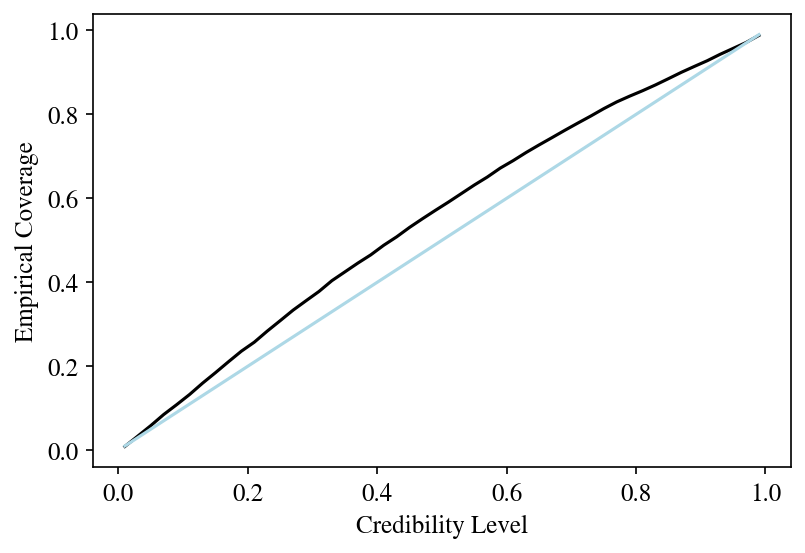

In [199]:
y_testframe = pd.DataFrame(y_test,columns=["Mdyn",'Mpm', r"$\phi$",r"$cos(\theta$)"])
cover_test_sbi(y_testframe,posterior_dist)

In [212]:
import pymc as pm
import arviz as az
label_parameter = ["Mdyn",'Mpm', r"$\phi$",r"$cos(\theta$)"]
credibility_levels  = np.linspace(0.01,0.99,30)
coverage_list=[]
for levels in credibility_levels:
    count_inside=0
    count_outside=0
    count_inside_percentile = 0
    for m in range(len(posterior_dist)):
        for j in range(len(label_parameter)):
            #counting how many times the True parameter falls between the lower and upper cut
            #We are not only counting for one parameter but for all 4 parameters and then dividing by the total number
            cut = az.hdi(posterior_dist[m,:,j], levels)
            lower_cut = cut[0]
            upper_cut = cut[1]
            #second method using quartile:
            lower_quantile = (1 - levels) / 2
            upper_quantile = 1 - (1 - levels) / 2

            # Find the parameter values corresponding to the quantiles
            lower_bound = np.quantile(posterior_dist[m,:,j], lower_quantile)
            upper_bound = np.quantile(posterior_dist[m,:,j], upper_quantile)
            #
            y_true = y_testframe[label_parameter[j]][m]
            if lower_bound<y_true<upper_bound:
                count_inside_percentile = count_inside_percentile+1
            
            if lower_cut<y_true<upper_cut:
                count_inside = count_inside+1
            else:
                count_outside = count_outside+1   
    #coverage_list = (Empirical coverage, counts inside the range, counts outside the range,total always summing up to 2000.0 ,credible region (1-Alpha))
    coverage_list.append([count_inside/float(len(posterior_dist)*len(label_parameter)),count_inside_percentile/float(len(posterior_dist)*len(label_parameter)),count_inside,count_outside,count_inside+count_outside,levels])    
coverage_list = np.array(coverage_list)    
    

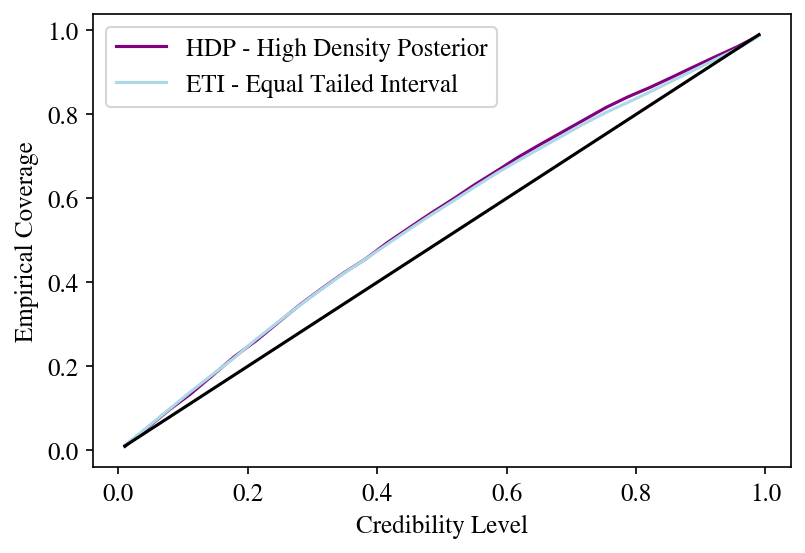

In [213]:
plt.figure(dpi=150)
plt.plot(coverage_list[:,5],coverage_list[:,0], color='purple', label='HDP - High Density Posterior')
plt.plot(coverage_list[:,5],coverage_list[:,1], color='lightblue', label='ETI - Equal Tailed Interval')
plt.plot(coverage_list[:,5],coverage_list[:,5], color='black')
plt.legend()
plt.xlabel('Credibility Level')
plt.ylabel('Empirical Coverage')
plt.show()

# CORNER PLOT X TEST

In [239]:
def spectrum_maker_X_test(kncomb,nonormkncomb,y_test,nspec,plotdist,dia123=False,std=True, dietrich = True, save= False):
    import corner
    from matplotlib import cm
    cmap = cm.get_cmap('magma')
    colors = cmap(np.linspace(0,0.85,9))
    a  = ["Mdyn",'Mpm',r"$\phi$",r"$cos(\theta)$"]
    wl_sim = np.linspace(5000.0, 8000.0, 550)
    #posterior_samples = hatp_x_y.sample((5000,),x = torch.as_tensor(kncomb.astype(float)).to('cuda'),show_progress_bars=True).cpu().numpy()
    posterior_samples = sample_ensemble(kncomb)[0]
    thetas = []
    maxtheta=[]
    support = [np.linspace(0,0.02, 100),np.linspace(0.01,0.13, 100),np.linspace(0,90, 100),np.linspace(0,1, 100)]
    for i in range(4):
        kdec = gaussian_kde(posterior_samples[:,i])
        #Samplando os valores dentro da gaussian
        yc = kdec(support[i])
        #pegando o valor mais provavel
        maxtheta.append(support[i][np.argmax(yc)])
        #maxcos = support[np.argmax(yc)]
    thetas.append(maxtheta)
    maxtheta = np.array(maxtheta)
    print(maxtheta)
    ##Create a figure and a grid of subplots
    fig, axs = plt.subplots(1, 4, figsize=(20, 4),dpi=100)
    # Plot data in each subplot
    axs[0].hist(posterior_samples[:,0],bins=120)
    axs[0].set_title('Parameter "Mdyn" distribution')
    axs[0].legend(['Most probable value: '+str(np.round(maxtheta[0],5))])

    axs[1].hist(posterior_samples[:,1],bins=120)
    axs[1].set_title('Parameter "Mpm" distribution')
    axs[1].legend(['Most probable value: '+str(np.round(maxtheta[1],5))])

    axs[2].hist(posterior_samples[:,2],bins=120)
    axs[2].set_title(r'Parameter $\phi$ distribution')
    axs[2].legend(['Most probable value: '+str(np.round(maxtheta[2],5))])

    axs[3].hist(posterior_samples[:,3],bins=120)
    axs[3].set_title(r'Parameter $cos\theta$ distribution')
    axs[3].legend(['Most probable value: '+str(np.round(maxtheta[3],5))])
    plt.tight_layout()
    if save==True:
        plt.savefig('/tf/dados10Tdock2/phelipedata/KNfits/Notebooks/Dietrich_Models/OVERLEAF_PLOT/'+str(MODEL)+'_'+'Dietrich_'+str(RUIDO)+'_smooth_'+str(SMOOTH)+'_'+'Model_Gaussian_error_plot_histogram_'+str(KN[0])+str(KN[1])+str(KN[2]),dpi=300)   

    plt.show()
    nsamples = nspec
    
    
    
    import random
    spectrumsampled = []
    # posterior_samples[:,0]=np.clip(posterior_samples[:,0],1e-3,2e-2)
    # posterior_samples[:,1]=np.clip(posterior_samples[:,1],1e-2,0.13)
    for i in range(nsamples):
        md=random.choice(posterior_samples[:,0])
        mp= random.choice(posterior_samples[:,1])
        phi= random.choice(posterior_samples[:,2])
        the= random.choice(posterior_samples[:,3])
        # prior = utils.BoxUniform(low = torch.tensor([1e-3, 1e-2, 0.0, 0.0]), 
        #                  high = torch.tensor([2e-2, 0.13, 90, 1.0]))
        
        params = np.array([md,mp,phi,the])
        if dia123 ==True:
            text = ['1','2','3']
            spec_sim = simulate_spec_noiseless123(params)
        else:
            text = ['1.5','2.5','3.5']
            spec_sim = simulate_spec_noiseless(params)


        spectrumsampled.append(spec_sim)
    if dia123 ==True:
        spec_pred = simulate_spec_noiseless123(np.array(maxtheta))
        die_spec =  simulate_spec_noiseless123(np.array([0.005370317963702527, 0.05248074602497726, 49.5, 0.7337298645028765]))
    else:
        spec_pred = simulate_spec_noiseless(np.array(maxtheta))
        die_spec =  simulate_spec_noiseless(np.array([0.005370317963702527, 0.05248074602497726, 49.5, 0.7337298645028765]))
        
    
    
    data = np.array(spectrumsampled).astype(float)
    print(data.shape)
    nonormdata = np.copy(data)
    nonormdata_maxtheta = np.copy(spec_pred)
    if std==True:
        for x in range(3):
            mean2 = np.mean(spec_pred[:,x])
            std2 = np.std(spec_pred[:,x])
            spec_pred[:,x] = (spec_pred[:,x]-mean2)/abs(std2)
        for i in range(len(data)):
            for j in range(3):
                mean1 = np.mean(data[i][:,j])
                std1 = np.std(data[i][:,j])
                data[i][:,j] = (data[i][:,j]-mean1)/abs(std1)
                
    else:
        #normalizar:
        for z in range(3):
            mean2 = np.min(spec_pred[:,z])
            std2 = np.max(spec_pred[:,z])
            spec_pred[:,z] = (spec_pred[:,z]-mean2)/abs(std2-mean2)
        for i in range(len(data)):
            for j in range(3):
                mini = np.min(data[i][:,j])
                maxi = np.max(data[i][:,j])
                data[i][:,j] = (data[i][:,j]-mini)/abs(maxi-mini)


    print('\n')
    print('\n')
    print('\n')
    print('\n')
    print('\n')
    # Create a new figure and axis object
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(25, 5),dpi=150)

    # Plot each line on the same set of axes
    for i in range(data.shape[0]):
        ax[0].plot(wl_sim,nonormdata[i][:,0],color="lightblue", zorder=0, alpha=0.3)
        ax[1].plot(wl_sim,nonormdata[i][:,1],color="lightblue", zorder=0, alpha=0.3)
        ax[2].plot(wl_sim,nonormdata[i][:,2],color="lightblue", zorder=0, alpha=0.3)
    ax[0].plot(wl_sim,nonormdata_maxtheta[:,0],color='black',label=r'$p_φ(f(θ)|x_{obs})$', zorder=1,lw=3, ls='--')
    ax[1].plot(wl_sim,nonormdata_maxtheta[:,1],color='black',label=r'$p_φ(f(θ)|x_{obs})$', zorder=1,lw=3, ls='--')
    ax[2].plot(wl_sim,nonormdata_maxtheta[:,2],color='black',label=r'$p_φ(f(θ)|x_{obs})$', zorder=1,lw=3, ls='--')


    # Add a legend to the plot
    #ax.legend()

    # Add labels and a title to the plot
    ax[0].plot(wl_sim, nonormkncomb[:,0][0],label=r'$f(θ_{obs})$ - Day: 1.5',color='orange',lw=2, alpha=0.8)
    ax[1].plot(wl_sim, nonormkncomb[:,1][0],label=r'$f(θ_{obs})$ - Day: 2.5 ',color='orange',lw=2, alpha=0.8)
    ax[2].plot(wl_sim, nonormkncomb[:,2][0],label=r'$f(θ_{obs})$ - Day: 3.5' ,color='orange',lw=2, alpha=0.8)
    # ax[0].set_title("Reconstrução espectro dia " +str(text[0])+' -'+str(nsamples)
    # ax[1].set_title("Reconstrução espectro dia " +str(text[1])+' -'+str(nsamples)
    # ax[2].set_title("Reconstrução espectro dia "  +str(text[2])+' -'+str(nsamples)
    ax[0].set_xlabel("Wavelength (A)")
    ax[0].set_ylabel("Flux")
    ax[1].set_xlabel("Wavelength (A)")
    ax[1].set_ylabel("Flux")
    ax[2].set_xlabel("Wavelength (A)")
    ax[2].set_ylabel("Flux")
    #box = ax[0].get_position()
    #ax[0].set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    ax[0].legend()
    ax[1].legend()
    ax[2].legend()

    # Display the plot
    if save==True:
        plt.savefig('/tf/dados10Tdock2/phelipedata/KNfits/Notebooks/Dietrich_Models/OVERLEAF_PLOT/'+str(MODEL)+'_'+'Dietrich_'+str(RUIDO)+'_smooth_'+str(SMOOTH)+'_'+'Model_Gaussian_error_plot_spectra_'+str(KN[0])+str(KN[1])+str(KN[2]),dpi=300)   
    plt.show()
           
    
    if plotdist == True:
        
        posterior_samples[:, 0] = np.log10(posterior_samples[:,0])
        posterior_samples[:, 1] = np.log10(posterior_samples[:,1])
        posterior_samples[:,3] = np.rad2deg(np.arccos(posterior_samples[:,3]))
        #------------------------------------------------------
        maxtheta[0] = np.log10(maxtheta[0])
        maxtheta[1] = np.log10(maxtheta[1])
        maxtheta[3] = np.rad2deg(np.arccos(maxtheta[3]))
        y_test[0] = np.log10(y_test[0])
        y_test[1] = np.log10(y_test[1])
        y_test[3] = np.rad2deg(np.arccos(y_test[3]))
        print(maxtheta)
        print(y_test)
        
        #------------------------------------------------------
        print('\n')
        print('\n')
        print('\n')
        print('\n')
        print('\n')
        figure = corner.corner(posterior_samples, show_titles=False, 
                               quantiles=[0.05,0.5, 0.95],  
                               levels=[0.1,0.32, 0.68, 0.95], 
                               labels=[r'$log_{10}(M_{ej, dyn}/M_{\odot})$', \
                                       r'$log_{10}(M_{ej, pm}/M_{\odot})$', \
                                       r'$\Phi$[deg]', \
                                       r'$\Theta_{obs}$[deg]'], 
                               truths = y_test,
                               color= 'lightblue',
                               title_kwargs={"fontsize": 19},
                               bins=20,
                               contour_kwargs={"linewidths": 2, "colors": "black"},
                               hist_kwargs={"histtype": "step", "linewidth": 3, "alpha": 0.7},
                              truth_color=colors[7],
                              smooth=1.0, verbose=True)

        figure2 = corner.corner(posterior_samples, show_titles=True, fig=figure, 
                               levels=[0.1,0.32, 0.68, 0.95], 
                               title_kwargs={"fontsize": 19},
                               bins=20,
                              truth_color=colors[7],smooth=1.0)
    
        plt.subplots_adjust(top=0.9)  # Adjust title position
        

        axes = np.array(figure.axes).reshape((4, 4))
        for i in range(4):
            ax = axes[i,i]
            label0 = ['SNPE Model','','','']
            #valor mais provavel: ---- no
            ax.axvline(np.quantile(posterior_samples, 0.5, axis=0)[i],  linestyle='-', color='k', label=label0[i])
            ax.axvline(np.quantile(posterior_samples, 0.05, axis=0)[i],  linestyle='--', color='k')
            ax.axvline(np.quantile(posterior_samples, 0.95, axis=0)[i],  linestyle='--', color='k')
            
            
        
        if save==True:        
            plt.savefig('/tf/dados10Tdock2/phelipedata/KNfits/Notebooks/Dietrich_Models/OVERLEAF_PLOT/'+str(MODEL)+'_'+'Dietrich_'+str(RUIDO)+'_smooth_'+str(SMOOTH)+'_'+'Model_Gaussian_error_plot_cornerPLOT_'+str(KN[0])+str(KN[1])+str(KN[2]),dpi=300)   
        plt.show()       
        
    else:
        print('end')

[1.13131313e-02 2.81818182e-02 8.27272727e+01 7.27272727e-01]


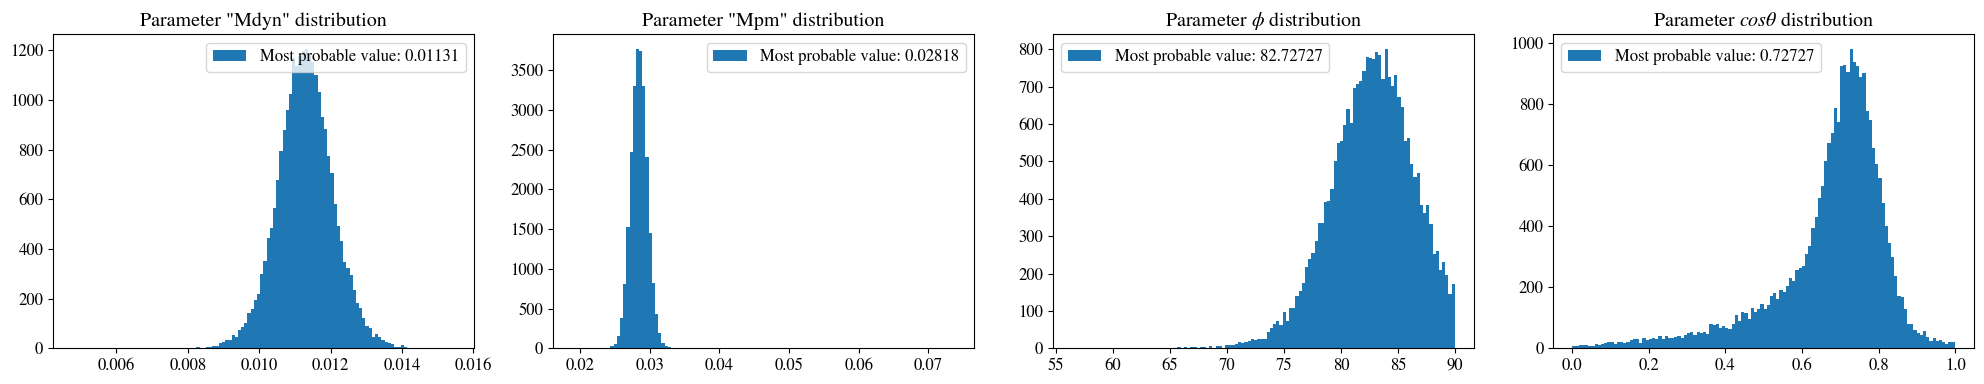

(200, 550, 3)












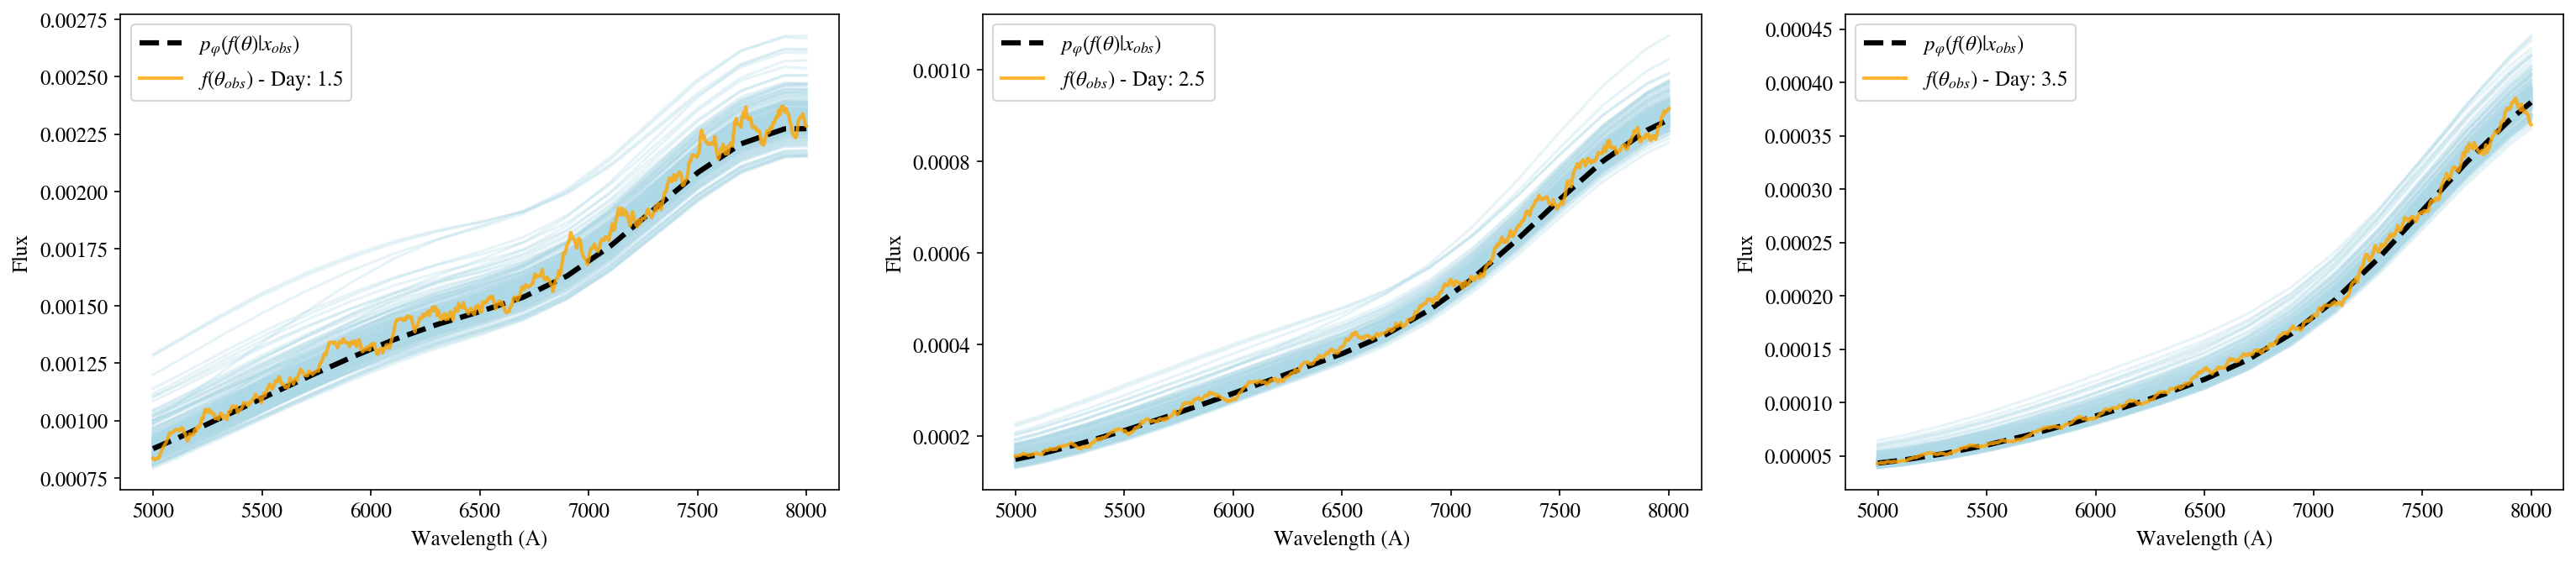

[-1.94641717 -1.55003099 82.72727273 43.34175823]
[-1.97185291 -1.54350872 78.65526581 50.92273109]










Quantiles:
[(0.05, -1.9986615189796433), (0.5, -1.947518400029748), (0.95, -1.9001226333912362)]
Quantiles:
[(0.05, -1.5758997781415103), (0.5, -1.545762877422998), (0.95, -1.5165698729076451)]
Quantiles:
[(0.05, 76.54213905334473), (0.5, 82.83308792114258), (0.95, 88.28204002380372)]
Quantiles:
[(0.05, 32.55594935749778), (0.5, 44.84476039339421), (0.95, 68.60005620854632)]


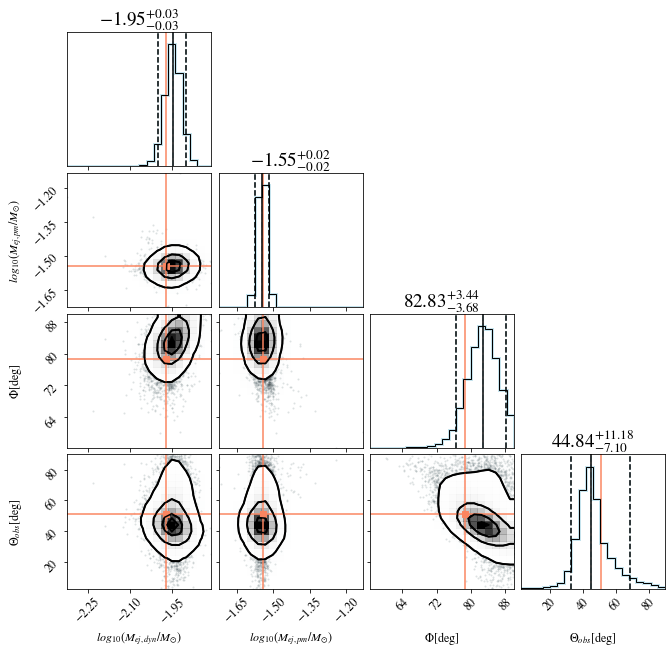

---------------------------SMOOTH:1-----complete ---------------------------


In [240]:
smooth_applied = [1]
idx_test = 35
for smooth in smooth_applied:
    #X_test[idx_test,:,:] = scipy.ndimage.uniform_filter1d(X_test[idx_test,:,:],smooth)
    spectrum_maker_X_test(kncomb=X_test[idx_test:idx_test+1,:,:],nonormkncomb=scipy.ndimage.uniform_filter1d(X_test[idx_test:idx_test+1,:,:],15),y_test = y_test[idx_test].flatten(),nspec=200,plotdist=True,dia123=False,std=True, dietrich = False, save= False)
    print('---------------------------SMOOTH:'+str(smooth)+'-----complete ---------------------------')

# CORNER PLOT ATF2017gfo

In [ ]:
KN = [4,5,7]
chartimes15 =np.array([0,4])
chartimes25 =np.array([1,5,6])
chartimes35 =np.array([2,7])

# B) Noise from the Real KN

In [49]:
# X_datakilonet = np.load('std_gaussian_erro_smooth2_spectra_simulated.npy')
# theta = np.load('std_gaussian_erro_smooth2_parameters_simulated.npy')

In [50]:
# for i in range(len(knreal2)):
#     mean= np.mean(knreal2[i][:,1])
#     std = np.std(knreal2[i][:,1])
#     knreal2[i][:,1] = (knreal2[i][:,1]-mean)/abs(std)

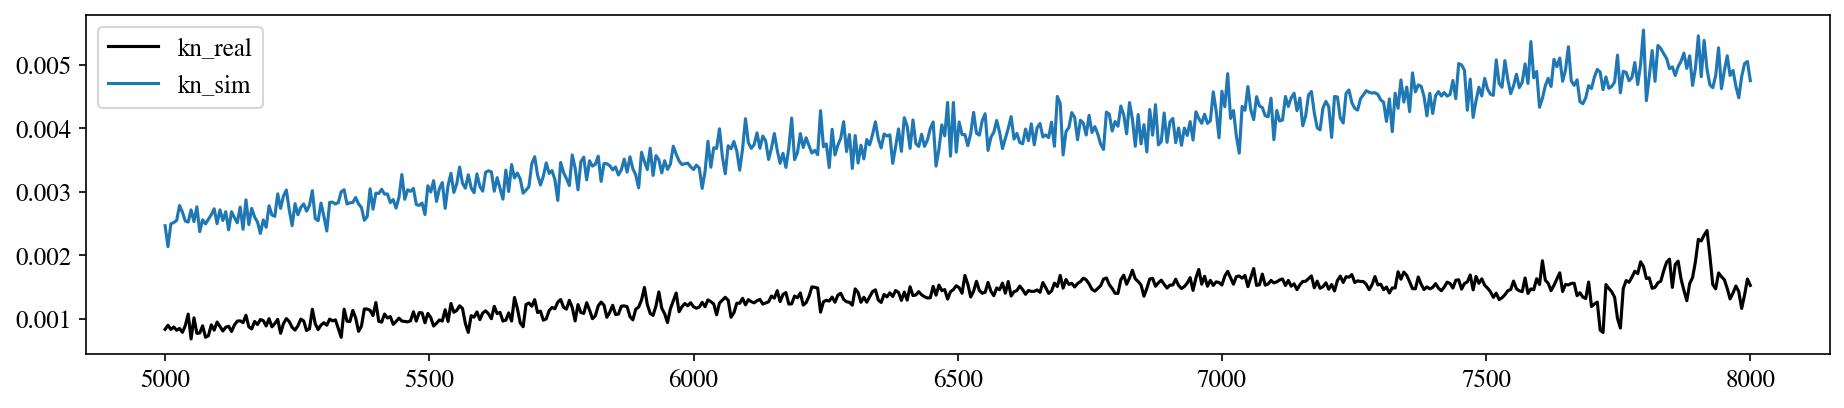

In [58]:
import scipy
plt.figure(figsize=(15,3), dpi=150)
plt.plot(wl_sim,knreal2[5,:,1], color='black',label='kn_real')
plt.plot(wl_sim,X_datakilonet[2,:,0] ,label='kn_sim')
#plt.plot(wl_sim,scipy.ndimage.uniform_filter1d(X_datakilonet[4,:,0],6),label='kn_sim smooth')
plt.legend()
plt.show()

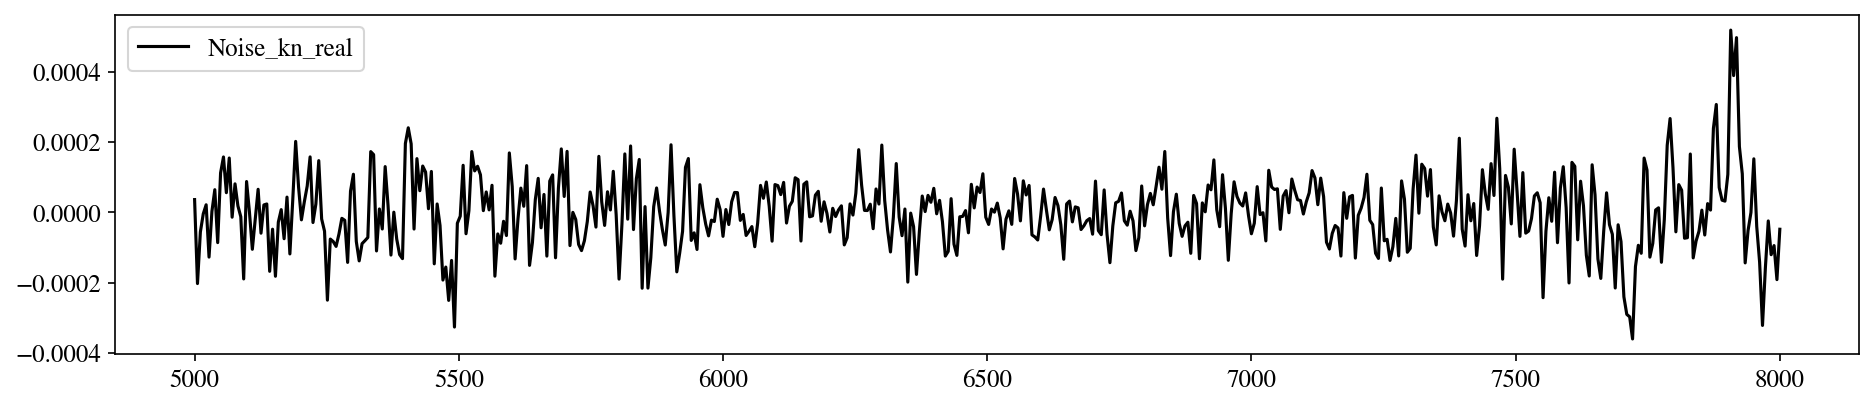

In [57]:
plt.figure(figsize=(15,3), dpi=150)
plt.plot(wl_sim,knreal2[7,:,1] -scipy.ndimage.uniform_filter1d(knreal2[7,:,1],100), color='black',label='Noise_kn_real')
#plt.plot(wl_sim,X_datakilonet[4,:,0]-scipy.ndimage.uniform_filter1d(X_datakilonet[4,:,0],15) ,label='kn_sim')
#plt.plot(wl_sim,scipy.ndimage.uniform_filter1d(knreal2[3,:,1]-scipy.ndimage.uniform_filter1d(knreal2[3,:,1],50),60),label='kn_sim smooth')
plt.legend()
plt.show()

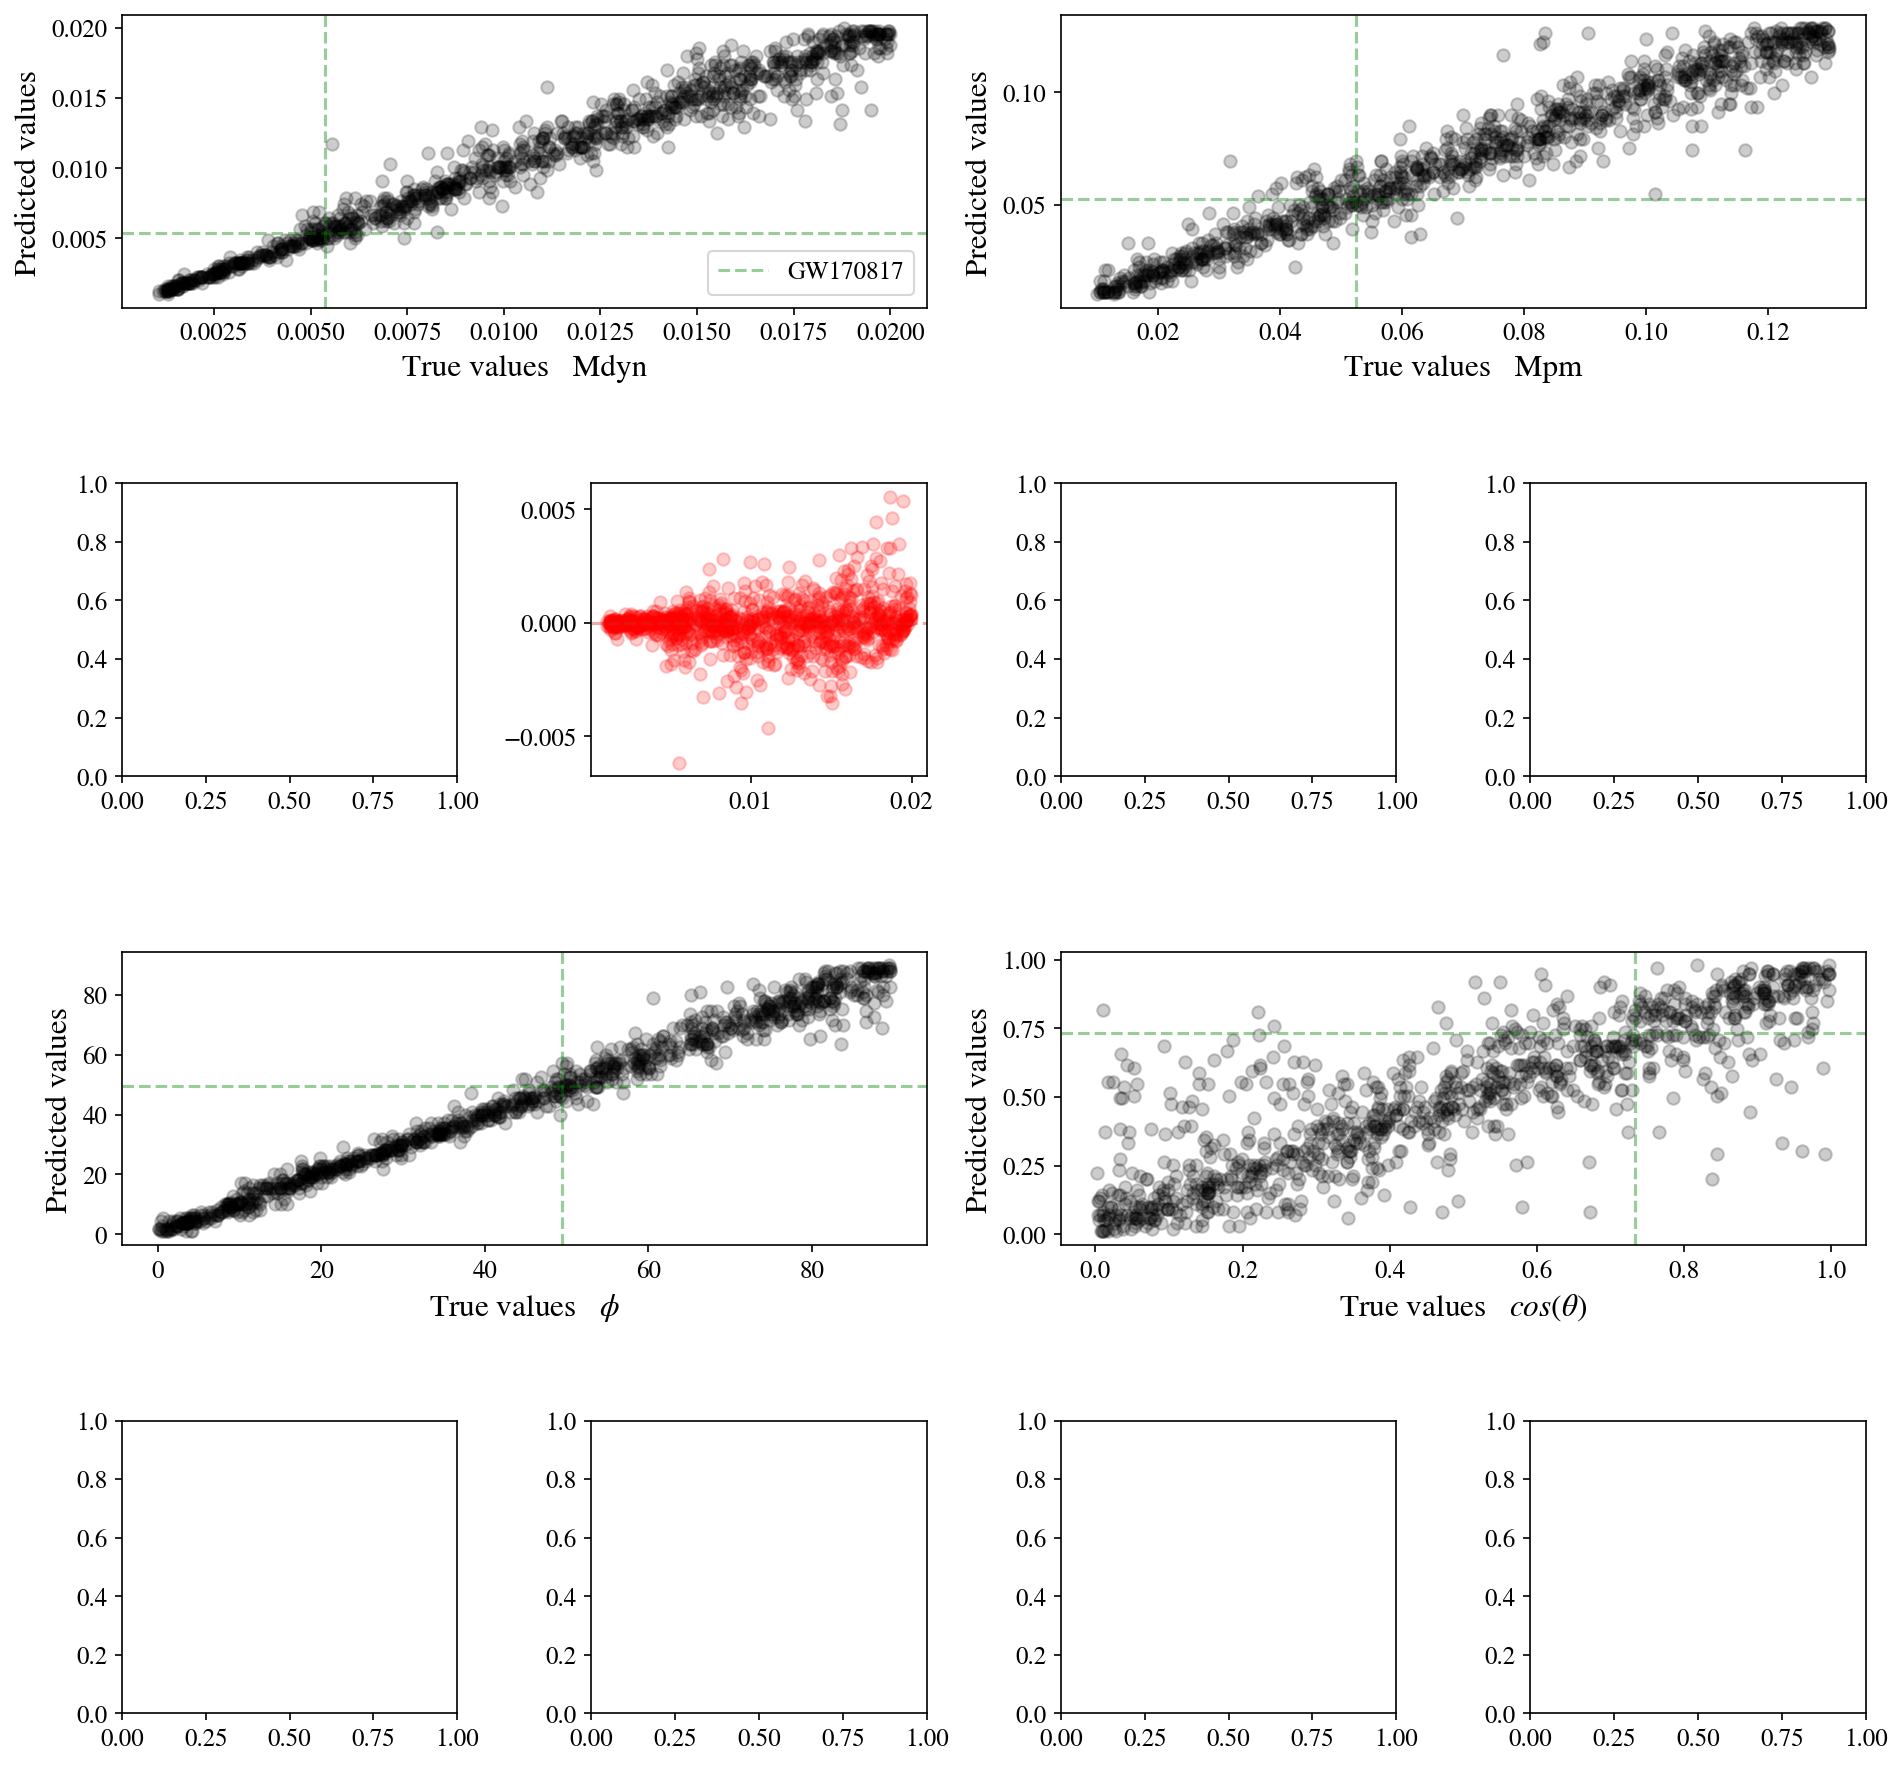

In [221]:
fig = plt.figure(dpi=150, figsize=(15,15))
fig.subplots_adjust(wspace=0.4, hspace=0.6)
ax1 = plt.subplot2grid((4, 4), (0, 0), colspan=2)
ax2 = plt.subplot2grid((4, 4), (0, 2), colspan=2)
ax3 = plt.subplot2grid((4, 4), (2, 0), colspan=2)
ax4 = plt.subplot2grid((4, 4), (2, 2), colspan=2)  
#-------------------------------------------------
ax12 = plt.subplot2grid((4,4), (1, 0))              
ax12 = plt.subplot2grid((4,4), (1, 1))     

ax21 = plt.subplot2grid((4,4), (1, 2))              
ax22 = plt.subplot2grid((4,4), (1, 3))  

#---------------------------------------
ax31 = plt.subplot2grid((4,4), (3, 2))              
ax32 = plt.subplot2grid((4,4), (3, 3))  
ax41 = plt.subplot2grid((4,4), (3, 0))              
ax42 = plt.subplot2grid((4,4), (3, 1))    



# Plot scatter plot of predicted vs true values
residuals = np.array(true_values - predicted_values)
ax12.scatter(true_values, residuals , color='red', alpha=0.2)
ax12.axhline(y=0, color='C3', linestyle='--', alpha=0.4)
# Share x-axis between ax1 and ax2.
ax1.get_shared_x_axes().join(ax1, ax12)
#linha do mean residual:
ax1.scatter(true_values, predicted_values , color='black', alpha=0.2)
ax1.set_xlabel('True values   '+a[0],fontsize=15)
ax1.set_ylabel('Predicted values   ',fontsize=15)
ax1.axhline(y=Gw_dietrich[0], color='g', linestyle='--', label='GW170817', alpha=0.4)
ax1.axvline(x=Gw_dietrich[0], color='g', linestyle='--', alpha=0.4)
 


#ax1.text(0.85, 0.1,  f"R-squared: {r2:.3f}", horizontalalignment='center',verticalalignment='center', transform=axes[0,0].transAxes,fontsize=12)

ax1.legend()

# Plot scatter plot of predicted vs true values
ax2.scatter(true_values1, predicted_values1 , color='black', alpha=0.2)
ax2.set_xlabel('True values   '+a[1],fontsize=15)
ax2.set_ylabel('Predicted values   ',fontsize=15)
ax2.axhline(y=Gw_dietrich[1], color='g', linestyle='--', label='GW170817', alpha=0.4)
ax2.axvline(x=Gw_dietrich[1], color='g', linestyle='--', alpha=0.4)
#axes[0].set_title(a[i]+' Scatter plot of predicted vs true values',fontsize=20)
#ax2.text(0.85, 0.1,  f"R-squared: {r21:.3f}", horizontalalignment='center',verticalalignment='center', transform=axes[0,1].transAxes,fontsize=12)
#ax2.legend()


# Plot scatter plot of predicted vs true values
ax3.scatter(true_values2, predicted_values2 , color='black', alpha=0.2)
ax3.set_xlabel('True values   '+a[2],fontsize=15)
ax3.set_ylabel('Predicted values   ',fontsize=15)
ax3.axhline(y=Gw_dietrich[2], color='g', linestyle='--', label='GW170817', alpha=0.4)
ax3.axvline(x=Gw_dietrich[2], color='g', linestyle='--', alpha=0.4)
#axes[0].set_title(a[i]+' Scatter plot of predicted vs true values',fontsize=20)
#ax3.text(0.85, 0.1,  f"R-squared: {r22:.3f}", horizontalalignment='center',verticalalignment='center', transform=axes[1,0].transAxes,fontsize=12)
#ax3.legend()



# Plot scatter plot of predicted vs true values
ax4.scatter(true_values3, predicted_values3 , color='black', alpha=0.2)

ax4.set_xlabel('True values   '+a[3],fontsize=15)
ax4.set_ylabel('Predicted values   ',fontsize=15)
ax4.axhline(y=Gw_dietrich[3], color='g', linestyle='--', label='GW170817', alpha=0.4)
ax4.axvline(x=Gw_dietrich[3], color='g', linestyle='--', alpha=0.4)
#axes[0].set_title(a[i]+' Scatter plot of predicted vs true values',fontsize=20)
#ax4.text(0.85, 0.1,  f"R-squared: {r23:.3f}", horizontalalignment='center',verticalalignment='center', transform=axes[1,1].transAxes,fontsize=12)
#ax4.legend()


plt.show()

In [ ]:
def param_analysis(param): # param shape (test_size, n_samples)
    # Inicializando listas
    median_data = []
    sig1p_data = []
    sig2p_data = []
    sig3p_data = []
    sig1m_data = []
    sig2m_data = []
    sig3m_data = []
    
    # Loop sobre images
    for samples in param:
        median = np.median(samples)
        median_data.append(median)
        
        sig1p = np.quantile(samples, 0.5+0.34)
        sig1p_data.append(sig1p)
        
        sig1m = np.quantile(samples, 0.5-0.34)
        sig1m_data.append(sig1m)
        
        sig2p = np.quantile(samples, 0.5+0.34+0.13)
        sig2p_data.append(sig2p)
        
        sig2m = np.quantile(samples, 0.5-0.34-0.13)
        sig2m_data.append(sig2m)
        
        sig3p = np.quantile(samples, 0.5+0.34+0.13+0.02)
        sig3p_data.append(sig3p)
        
        sig3m = np.quantile(samples, 0.5-0.34-0.13-0.02)
        sig3m_data.append(sig3m)
        
    result = np.stack([median_data, sig1p_data, sig1m_data, sig2p_data, sig2m_data, sig3p_data, sig3m_data], axis=-1)
    
    return result # shape (test_size, 7), 7 pq median e 6 sigmas

def make_plots(results,
               param:str,
               plot_title,
               x_range:list=None,
               y_range:list=None,
              ):
    # setting plot parameters
    matplotlib.rcParams['mathtext.fontset'] = 'stix'
    matplotlib.rcParams['font.family'] = 'STIXGeneral'
    matplotlib.rcParams.update({'font.size': 20})
    
    # loading data
    param_df = results[[param+'_true', # Crio df apenas com colunas do parametro que quero
                        param+'_pred',
                        param+'_sig1m',
                        param+'_sig1p',
                        param+'_sig2m',
                        param+'_sig2p',
                        param+'_sig3m',
                        param+'_sig3p']].sort_values(by=[param+'_true']) # deixo valores ordenados

    # Binando
    bin_param = param_df.groupby(pd.cut(param_df[param+'_true'], 30)).agg('mean') # agrupo valores pela média a partir de bins (cut) no valor true

    # Plot
    fig, ax = plt.subplots(2, 2, figsize=(8,8), height_ratios=[4, 1], width_ratios=[4, 1])
    plt.suptitle(plot_title)
    
    # plot 1x1
    ax[0, 0].fill_between(bin_param[param+'_true'], bin_param[param+'_sig3m'], bin_param[param+'_sig3p'], alpha=0.3, color='C2')
    ax[0, 0].fill_between(bin_param[param+'_true'], bin_param[param+'_sig2m'], bin_param[param+'_sig2p'], alpha=0.6, color='C2')
    ax[0, 0].fill_between(bin_param[param+'_true'], bin_param[param+'_sig1m'], bin_param[param+'_sig1p'], alpha=0.9, color='C0')
    
    ax[0, 0].set_ylabel('Predicted')
    ax[0, 0].plot(bin_param[param+'_true'], bin_param[param+'_pred'], color='C8')
    
    if x_range:
        x_min, x_max = x_range
    else:
        x_min, x_max  = ax[0,0].get_xlim() # guardo limites gerados automaticamente pelo plot dos pontos
    if y_range:
        y_min, y_max = y_range
    else:
        y_min, y_max = ax[0,0].get_ylim()
    
    ax_min = min(x_min, y_min) # acho o menor entre os dois para garantir que a reta 1x1 tbm seja diagonal no plot
    ax_max = max(x_max, y_max)
    
    ax[0, 0].set_xlim(ax_min, ax_max) # forço esses limites no plot
    ax[0, 0].set_ylim(ax_min, ax_max)
    ax[0, 0].plot([-1000.0, 1000.0], [-1000.0, 1000.0], '--', color='k') # ploto reta com range absurdo
    ax[0, 0].grid(alpha=0.3)
    ax[0, 0].tick_params(axis='both', which='both',labelbottom= False,labelleft=True, labeltop = True,right=True, direction="in")
    
    # histograma true
    ax[1, 0].hist(param_df[param+'_true'], bins=30) #
    ax[1, 0].set_xlabel('True')
    ax[1, 0].set_xlim(ax_min, ax_max) # uso limtes do plot 1x1
    #ax[1, 0].set_ylim(ax_min, ax_max)
    #ax[1, 0].set_xlim(0, 1)
    ax[1, 0].grid(alpha=0.3)
    #ax[1,0].tick_params(direction="in")
    
    # histograma pred
    ax[0, 1].hist(param_df[param+'_pred'], bins=30, orientation='horizontal') #
    ax[0, 1].set_xlim(ax[0, 1].get_xlim()[::-1]) #invert the order of x-axis values
    ax[0, 1].yaxis.tick_right() #move ticks to the right
    #ax[0, 1].set_xlim(ax_min, ax_max) 
    ax[0, 1].set_ylim(ax_min, ax_max) # uso limites do plot 1x1
    #ax[0, 1].set_ylim(0, 1)
    ax[0, 1].grid(alpha=0.3)
    ax[0, 1].tick_params(axis='both', which='both',labelbottom= False, labelleft=False, labelright=True, labeltop=True, right=True)

    # subplot vazio
    ax[1, 1].axis('off')

    plt.tight_layout()
    plt.savefig(param+'_sim_1x1.jpg', format='jpeg', dpi=400)

In [31]:
theta2, X_test2 = simulate_for_sbi(simulator, proposal=prior, num_simulations=1000 ,num_workers=1)
X_test2 = np.array(X_test2).astype(float)
for i in range(len(X_test2)):
    for j in range(3):
        mean= np.mean(X_test2[i][:,j])
        std = np.std(X_test2[i][:,j])
        X_test2[i][:,j] = (X_test2[i][:,j]-mean)/abs(std)
X_test2 = np.swapaxes(X_test2[:,:,:],1,2)

Running 1000 simulations.:   0%|          | 0/1000 [00:00<?, ?it/s]

/opt/conda/lib/python3.8/site-packages/torch/nn/modules/rnn.py:761: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/aten/src/ATen/native/cudnn/RNN.cpp:926.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


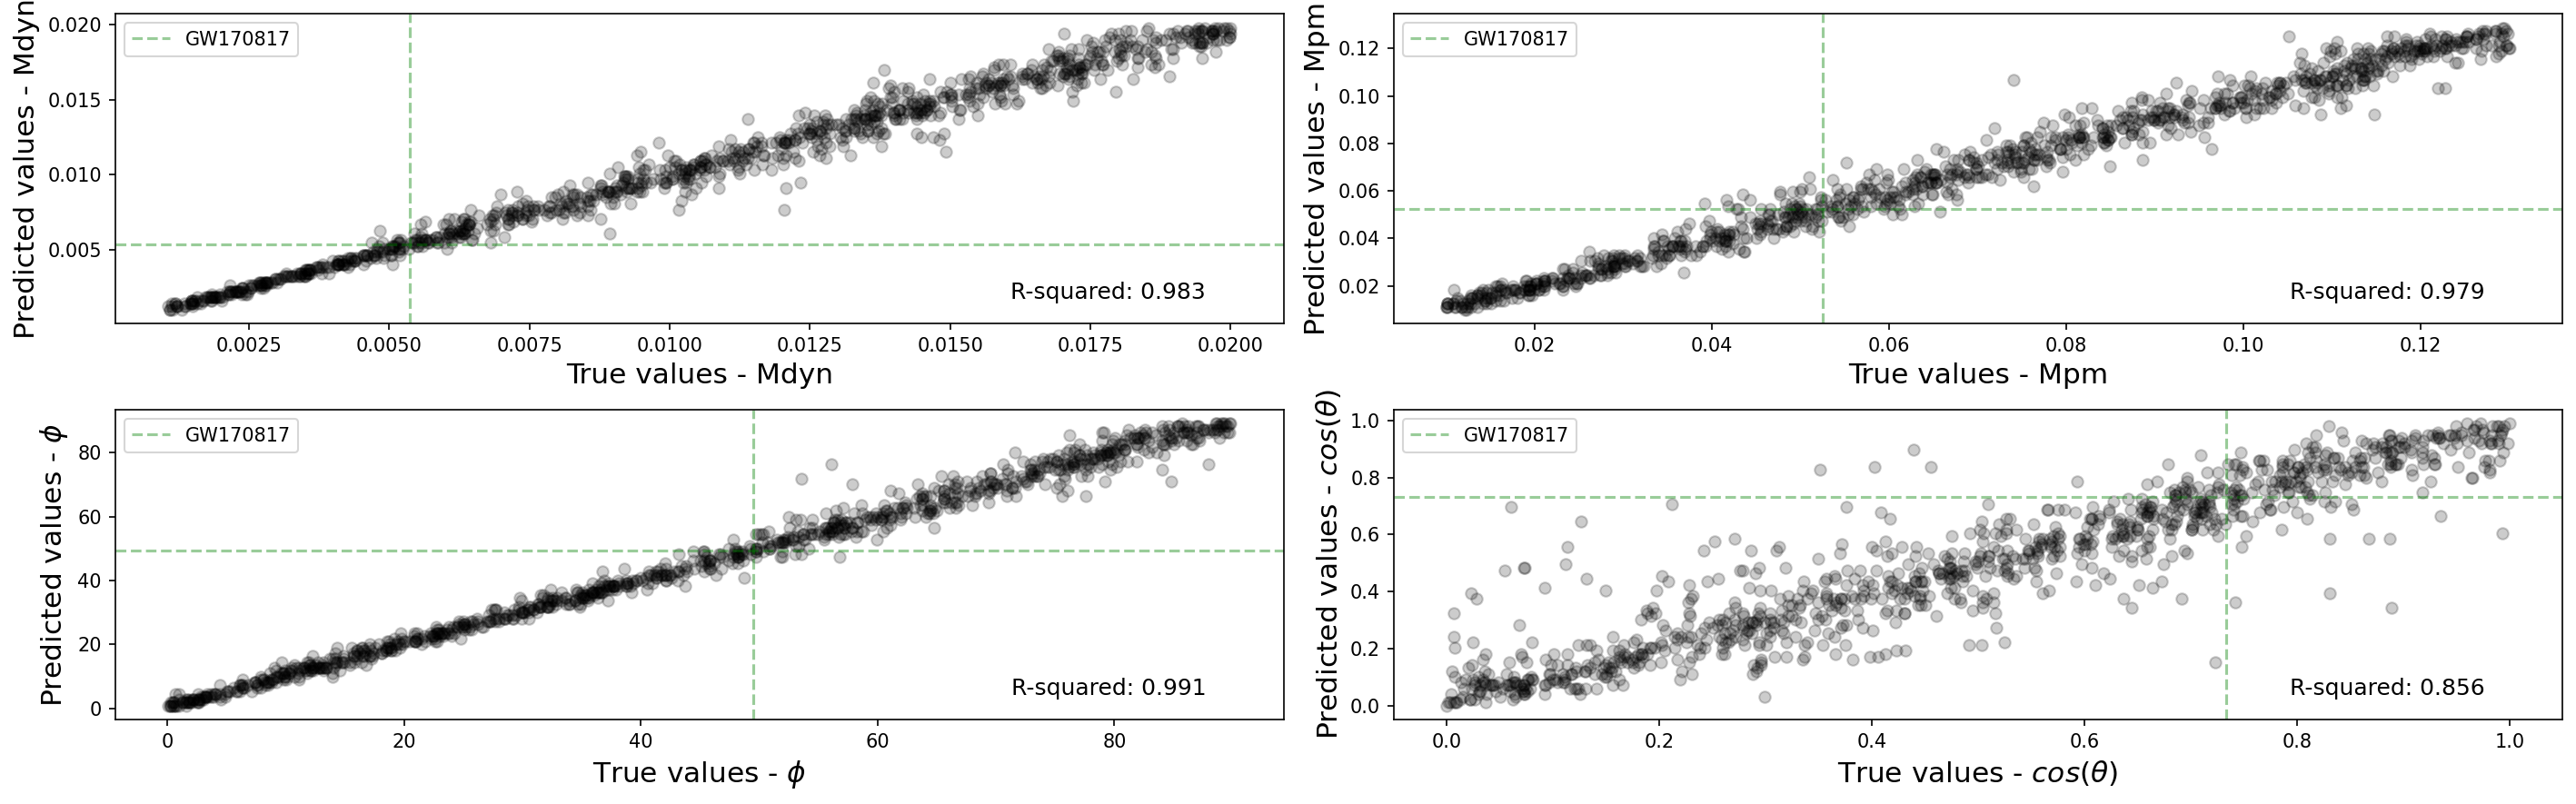

In [32]:
thetas = []
for j in range(len(X_test2[:1000])):
    maxtheta = []
    samples = hatp_x_y.sample((1000,),x = torch.as_tensor(X_test2[j:j+1]).to('cuda'),show_progress_bars=False).cpu().numpy()
    #support = [np.linspace(1e-2,9e-2, 100),np.linspace(1e-2,0.09, 100),np.linspace(0,1, 100)]
    support = [np.linspace(0,0.02, 100),np.linspace(0.01,0.13, 100),np.linspace(0,90, 100),np.linspace(0,1, 100)]
    for i in range(4):
        kdec = gaussian_kde(samples[:,i])
        #Samplando os valores dentro da gaussian
        yc = kdec(support[i])
        #pegando o valor mais provavel
        maxtheta.append(support[i][np.argmax(yc)])
        #maxcos = support[np.argmax(yc)]
    thetas.append(maxtheta)
maxtheta = np.array(maxtheta)
y_testframe = pd.DataFrame(theta2,columns=["Mdyn",'Mpm', r"$\phi$",r"$cos(\theta$)"])
thetas = pd.DataFrame(thetas,columns=["Mdyn",'Mpm', r"$\phi$",r"$cos(\theta$)"])
a  = ["Mdyn",'Mpm',r"$\phi$",r"$cos(\theta$)"]
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, explained_variance_score
Gw_dietrich = [0.005370317963702527, 0.05248074602497726, 49.5, 0.7337298645028765]

true_values = y_testframe[a[0]][:1000]
predicted_values = thetas[a[0]][:1000]

true_values1 = y_testframe[a[1]][:1000]
predicted_values1 = thetas[a[1]][:1000]

true_values2 = y_testframe[a[2]][:1000]
predicted_values2 = thetas[a[2]][:1000]

true_values3 = y_testframe[a[3]][:1000]
predicted_values3 = thetas[a[3]][:1000]

r2 = r2_score(true_values, predicted_values)
r21 = r2_score(true_values1, predicted_values1)
r22 = r2_score(true_values2, predicted_values2)
r23 = r2_score(true_values3, predicted_values3)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(19, 6),dpi=150)
# Plot scatter plot of predicted vs true values
axes[0,0].scatter(true_values, predicted_values , color='black', alpha=0.2)
axes[0,0].set_xlabel('True values - '+a[0],fontsize=15)
axes[0,0].set_ylabel('Predicted values - '+a[0],fontsize=15)
axes[0,0].axhline(y=Gw_dietrich[0], color='g', linestyle='--', label='GW170817', alpha=0.4)
axes[0,0].axvline(x=Gw_dietrich[0], color='g', linestyle='--', alpha=0.4)
#axes[0].set_title(a[i]+' Scatter plot of predicted vs true values',fontsize=20)
axes[0,0].text(0.85, 0.1,  f"R-squared: {r2:.3f}", horizontalalignment='center',verticalalignment='center', transform=axes[0,0].transAxes,fontsize=12)
axes[0,0].legend()

axes[0,1].scatter(true_values1, predicted_values1 , color='black', alpha=0.2)
axes[0,1].set_xlabel('True values - '+a[1],fontsize=15)
axes[0,1].set_ylabel('Predicted values - '+a[1],fontsize=15)
axes[0,1].axhline(y=Gw_dietrich[1], color='g', linestyle='--', label='GW170817', alpha=0.4)
axes[0,1].axvline(x=Gw_dietrich[1], color='g', linestyle='--', alpha=0.4)
#axes[0].set_title(a[i]+' Scatter plot of predicted vs true values',fontsize=20)
axes[0,1].text(0.85, 0.1,  f"R-squared: {r21:.3f}", horizontalalignment='center',verticalalignment='center', transform=axes[0,1].transAxes,fontsize=12)
axes[0,1].legend()


axes[1,0].scatter(true_values2, predicted_values2 , color='black', alpha=0.2)
axes[1,0].set_xlabel('True values - '+a[2],fontsize=15)
axes[1,0].set_ylabel('Predicted values - '+a[2],fontsize=15)
axes[1,0].axhline(y=Gw_dietrich[2], color='g', linestyle='--', label='GW170817', alpha=0.4)
axes[1,0].axvline(x=Gw_dietrich[2], color='g', linestyle='--', alpha=0.4)
#axes[0].set_title(a[i]+' Scatter plot of predicted vs true values',fontsize=20)
axes[1,0].text(0.85, 0.1,  f"R-squared: {r22:.3f}", horizontalalignment='center',verticalalignment='center', transform=axes[1,0].transAxes,fontsize=12)
axes[1,0].legend()



axes[1,1].scatter(true_values3, predicted_values3 , color='black', alpha=0.2)
axes[1,1].set_xlabel('True values - '+a[3],fontsize=15)
axes[1,1].set_ylabel('Predicted values - '+a[3],fontsize=15)
axes[1,1].axhline(y=Gw_dietrich[3], color='g', linestyle='--', label='GW170817', alpha=0.4)
axes[1,1].axvline(x=Gw_dietrich[3], color='g', linestyle='--', alpha=0.4)
axes[1,1].text(0.85, 0.1,  f"R-squared: {r23:.3f}", horizontalalignment='center',verticalalignment='center', transform=axes[1,1].transAxes,fontsize=12)
axes[1,1].legend()
plt.tight_layout()
plt.show()

# C) Generating spectral data for the Kilpatrick comparison

In [ ]:
# modelos = ['2813_nonorm152535','2813_std152535','2813_std123', '2813_nonorm123']
# melhores_parametros=[[0.00384,0.04758,29.09091,0.1313],[0.01313,0.07667,40,0.00001],[0.01152,0.12152,43.63,0.34343],[0.00404,0.04152,38.1818,0.2020]]

In [ ]:
#modelos = ['Kilonovanet_Article','012_CBPFModel_Kilpatrick','057_CBPFModel_Kilpatrick','452_CBPFModel_Kilpatrick','062_CBPFModel_Kilpatrick','457_CBPFModel_Kilpatrick']
#melhores_parametros=[[10**(-2.31), 10**(-1.13),47.98,np.cos(np.deg2rad(64.55))],[4.24242424e-03 ,5.96969697e-02, 2.45454545e+01, 2.02020202e-02],[2.62626263e-03, 5.96969697e-02, 2.27272727e+01, 0.00000000e+00],[3.43434343e-03, 6.33333333e-02, 2.90909091e+01, 9.09090909e-02],[4.24242424e-03, 6.57575758e-02, 2.72727273e+01, 1.21212121e-01],[2.62626263e-03, 5.60606061e-02, 2.45454545e+01, 2.02020202e-02]]

In [55]:
modelos = ['NeuroIPS_gaussian', 'NeuroIPS_gaussian_057','NeuroIPS_gaussian_062','testando']
melhores_parametros=[[6.46464646e-03, 7.18181818e-02, 4.81818182e+01, 5.15151515e-01],[6.06060606e-03 ,8.63636364e-02, 4.27272727e+01, 5.45454545e-01],[8.08080808e-03 ,6.69696970e-02, 4.27272727e+01, 4.74747475e-01],[10**(-1.88), 10**(-1.18),22.54,np.cos(np.deg2rad(40))]]

In [57]:
import math
for i in range(len(modelos)):
    a = simulate_spec_neuroips(np.array(melhores_parametros[i]))
    print(a.shape)
    np.save('/tf/dados10Tdock2/phelipedata/KilonovasDataset/Spectra_'+str(modelos[i]),a)

(550, 5)
(550, 5)
(550, 5)
(550, 5)


# D) POSTERIOR PREDICT CHECK 

In [235]:
def posterior_check(theta0,posterior,nsamples):
    knspec= simulate_spec(theta0)
    print(knspec.shape)
    knspec = np.expand_dims(knspec, axis = 0)

    knspec = np.swapaxes(knspec[:,:],2,1)
    #posterior_samples = posterior.sample((15000,),x = torch.as_tensor(knspec).to('cuda'),show_progress_bars=False).cpu().numpy()
    posterior_samples = sample_ensemble(knspec)[0]
    label = ["Mdyn",'Mpm',r"$\phi$",r"$cos(\theta$)"]
    fig1 , axes1 = plt.subplots(nrows=1, ncols=4, figsize=(14, 3),dpi=150)
    for i in range(len(label)):
        axes1[i].hist(posterior_samples[:,i],bins=60, density=True)
        axes1[i].grid(True)
        
        axes1[i].set_title('Parameter '+label[i]+' true value: '+str(theta0[i]) ,fontsize = 10)
        
    plt.show()
    import random
    data_kn1 = []
    data_kn2 = []
    data_kn3 = []
    for i in range(nsamples):
        md=random.choice(posterior_samples[:,0])
        mp= random.choice(posterior_samples[:,1])
        phi= random.choice(posterior_samples[:,2])
        costheta= random.choice(posterior_samples[:,3])
        parameters = np.array([md,mp,phi,costheta]).astype(float)
        knspec_pred = simulate_spec_noiseless(parameters)
        data_kn1.append(knspec_pred[:,0])
        data_kn2.append(knspec_pred[:,1])
        data_kn3.append(knspec_pred[:,2])

    data_kn1 = np.array(data_kn1).astype(float)
    data_kn2 = np.array(data_kn2).astype(float)
    data_kn3 = np.array(data_kn3).astype(float)
    # Create a new figure and axis object
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 7),dpi=200)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    # Plot each line on the same set of axes
    for i in range(data_kn1.shape[0]):
        axes[0].plot(wl_sim,data_kn1[i], label=f"Line {i+1}",color="lightblue", zorder=0)
        axes[1].plot(wl_sim,data_kn2[i], label=f"Line {i+1}",color="lightblue", zorder=0)
        axes[2].plot(wl_sim,data_kn3[i], label=f"Line {i+1}",color="lightblue", zorder=0)


    #ax.legend()

    # Add labels and a title to the plot
    axes[0].plot(wl_sim, knspec[0,0,:],label='Kilonova_X0 Day: 1.5',color='black')
    axes[1].plot(wl_sim, knspec[0,1,:],label='Kilonova_X0 Day: 2.5',color='black')
    axes[2].plot(wl_sim, knspec[0,2,:],label='Kilonova_X0 Day: 3.5',color='black')
    axes[0].set_xlabel("Wavelength")
    axes[2].set_ylabel("Flux")
    axes[0].set_title("Posterior Predictive Checks (PPC) in SBI - N_samples = "+str(nsamples))

    # Display the plot
    plt.show()

In [236]:
parameters = np.array([0.005370317963702527, 0.05248074602497726, 49.5, 0.7337298645028765])

(550, 3)


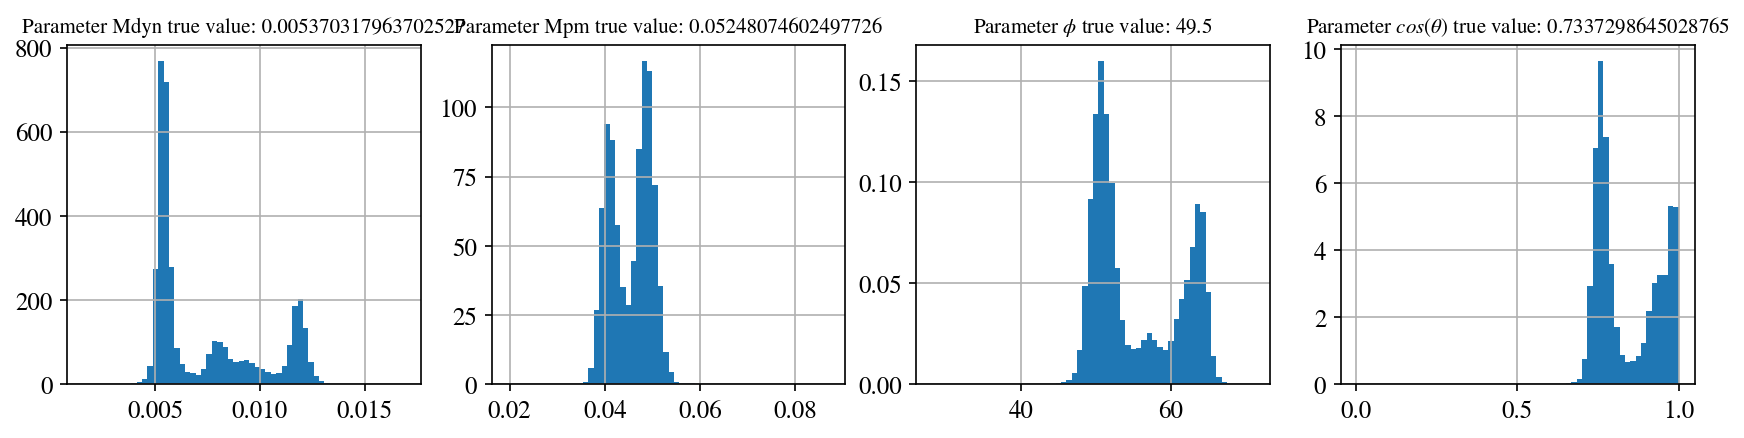

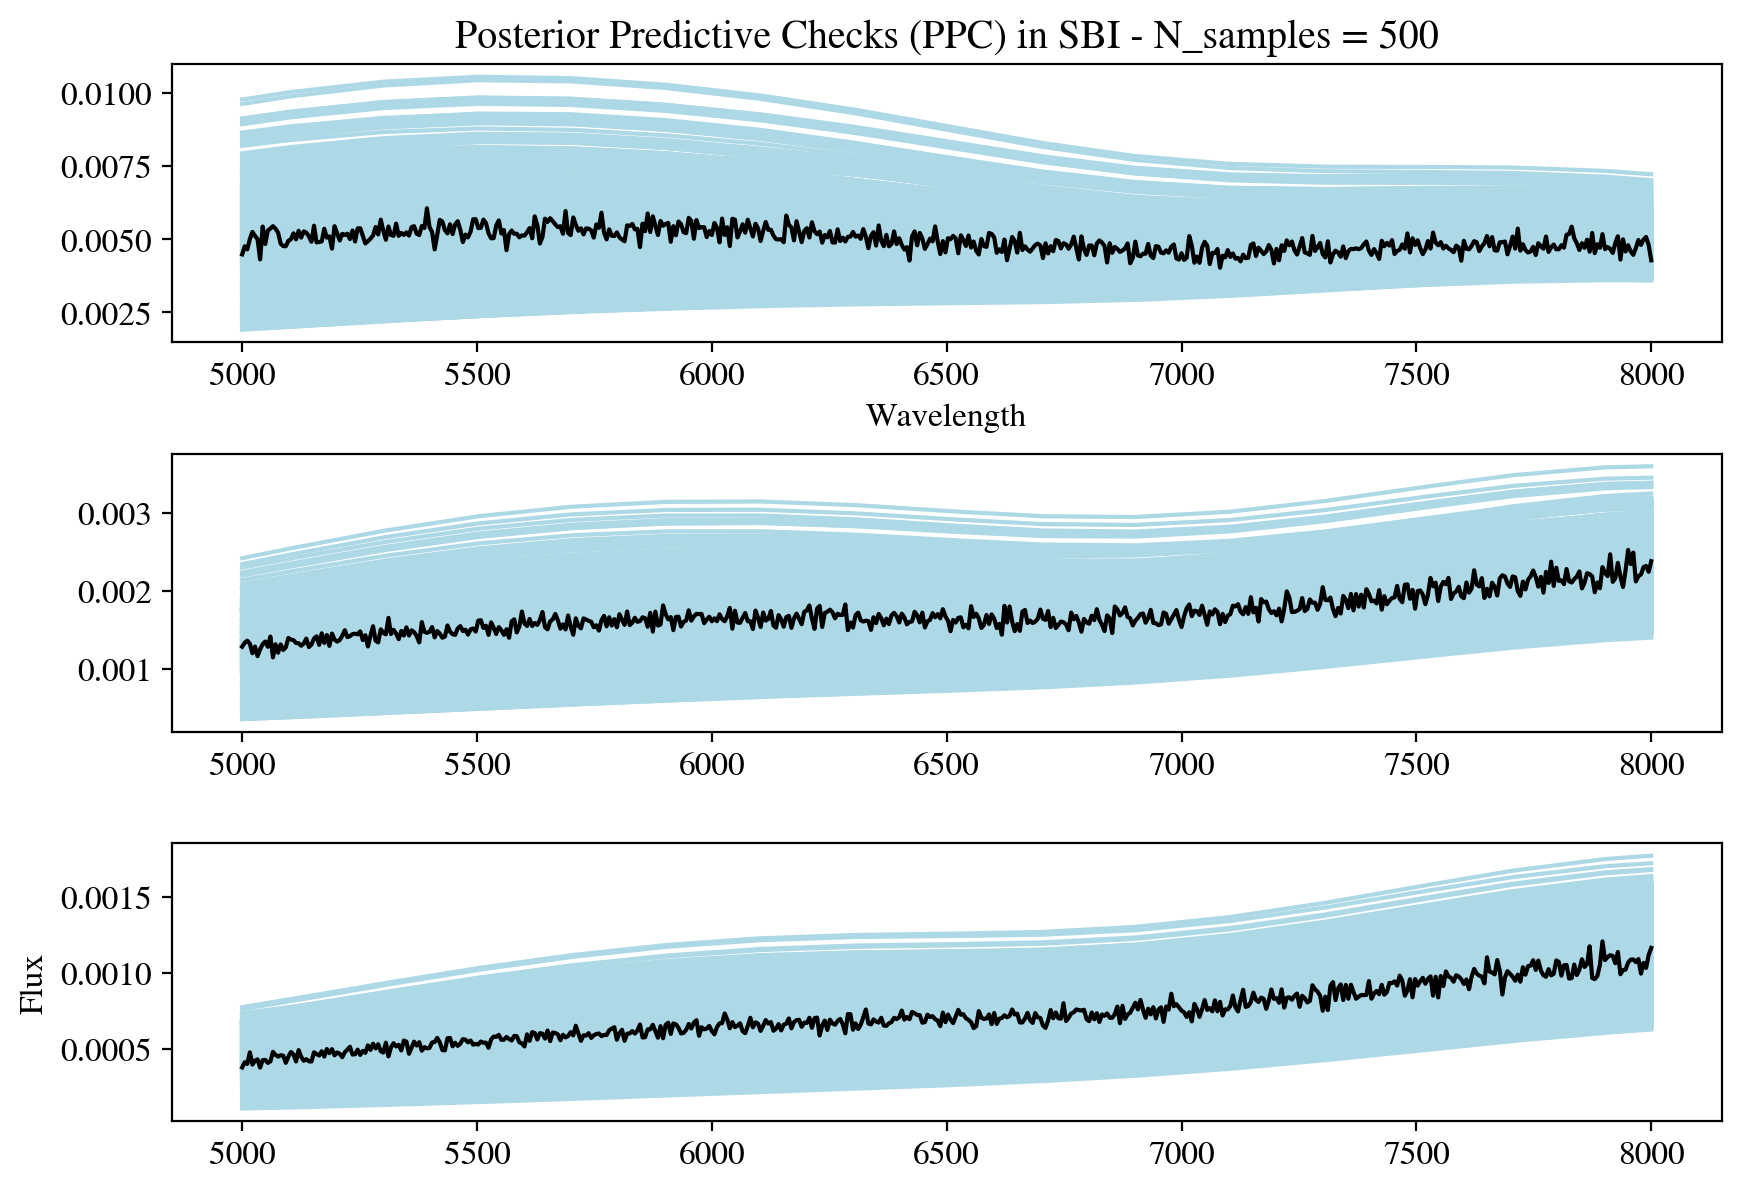

In [237]:
posterior_check(theta0 = parameters,posterior=hatp_x_y ,nsamples = 500)

# E) Extra - Hyperparametrization

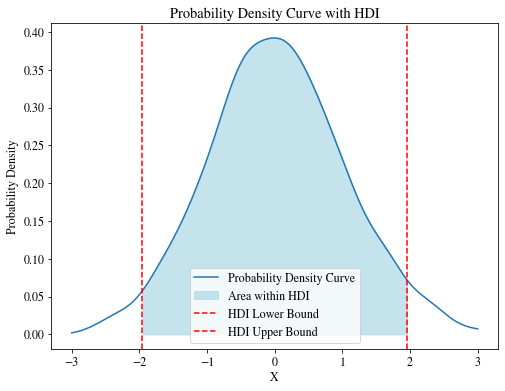

In [291]:
import numpy as np
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
from scipy.integrate import quad

# Example data
data = np.random.normal(0, 1, size=1000)

# Create a Gaussian KDE estimator for the data
kde = gaussian_kde(data)

# Define the HDI bounds (e.g., 95% HDI)
lower_bound = -1.96  # Lower bound for a 95% HDI for a standard normal distribution
upper_bound = 1.96   # Upper bound for a 95% HDI for a standard normal distribution

# Calculate the probability within the HDI
probability_within_HDI, _ = quad(kde.evaluate, lower_bound, upper_bound)

# Calculate the area (integral) within the HDI
hdi_width = upper_bound - lower_bound
area_within_HDI = probability_within_HDI * hdi_width

# Generate x values for plotting the PDF curve
x = np.linspace(-3, 3, 1000)

# Compute the PDF values at these x points
pdf_values = kde.evaluate(x)

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(x, pdf_values, label='Probability Density Curve')
plt.fill_between(x, pdf_values, where=(x >= lower_bound) & (x <= upper_bound), color='lightblue', alpha=0.7, label='Area within HDI')

# Highlight the HDI bounds
plt.axvline(lower_bound, color='red', linestyle='--', label='HDI Lower Bound')
plt.axvline(upper_bound, color='red', linestyle='--', label='HDI Upper Bound')

plt.xlabel('X')
plt.ylabel('Probability Density')
plt.legend()
plt.title('Probability Density Curve with HDI')
plt.show()

In [ ]:
import random
for j in range(100):
    testefilters1=random.choice([64,128,256,512])
    testefilters2=random.choice([64,128,256,512])
    testefilters3=random.choice([64,128,256,512])
    testeks1= random.choice([1,2,3])
    testeks2= random.choice([1,2,3])
    testeks3= random.choice([1,2,3])
    testelstm1= random.choice([400,200,300,600])
    testelstm2= random.choice([400,200,300,600])
    testeoutfeat = random.choice([5,10,20,100,50])
    sbimodel = random.choice(['nsf'])
    #print('Trial',j,'Bins:',a,'Numtransforms',b,'hidden features:',c, 'outfeatures: ', d,'model->',sbimodel)
    print('Trial',j,'filter1:',testefilters1 ,'filters2',testefilters2,' filters3: ',testefilters3, 'kernelsizepool123 : ',[testeks1,testeks2,testeks3],'LSTM hidden 1 e 2: ',
          [testelstm1,testelstm2],
          'Out feat:',testeoutfeat,
         'SBI model', sbimodel)
    class Model5(nn.Module):
        def __init__(self,filters1,filters2,filters3,ks1,ks2,ks3,lstm1,lstm2,outfeat):
            super().__init__()
            #padronizar aumentando os canais. tira a conv e tentar so LSTM
            #num filtro e tipos de funções de ativação
            self.conv1 = nn.Conv1d(in_channels=3, out_channels=filters1, kernel_size=2,padding='same')
            self.act1 = nn.ReLU()
            self.pool1 = nn.MaxPool1d(kernel_size=ks1, stride=ks1)
            #divide por 2
            self.conv2 = nn.Conv1d(in_channels=filters1, out_channels=filters2, kernel_size=2,padding='same')
            self.act2 = nn.ReLU()
            self.pool2 = nn.MaxPool1d(kernel_size=ks2, stride=ks2)
            #divide por 3
            self.conv3 = nn.Conv1d(in_channels=filters2, out_channels=filters3, kernel_size=2,padding='same')
            self.act3 = nn.ReLU()
            self.pool3 = nn.MaxPool1d(kernel_size=ks3, stride=ks3)
            #divide por 2
            #550/2*2*3
            self.lstm = nn.LSTM(input_size=filters3, hidden_size=lstm1, bidirectional=True, batch_first=True)
            self.lstm2 = nn.LSTM(input_size=lstm1*2, hidden_size=lstm2, bidirectional=True, batch_first=True)
            # in features do fc1 = 550/2*3*2 )* 256*2
            # 68
            self.flat = nn.Flatten()
            self.fc1 = nn.Linear(in_features=int((lstm2*2)*(int((550)/(ks1*ks2*ks3)))), out_features=outfeat)
            self.act4 = nn.ReLU()

        def forward(self, x):
            x = self.conv1(x)
            x = self.act1(x)
            x = self.pool1(x)
            #x = self.dropout1(x)
            x = self.conv2(x)
            x = self.act2(x)
            x = self.pool2(x)
            x = self.conv3(x)
            x = self.act3(x)
            x = self.pool3(x)
            x = torch.permute(x, (0,2,1)) 
            x, _ = self.lstm(x)
            x, _ = self.lstm2(x)
            x = self.flat(x)
            x = self.fc1(x)
            x = self.act4(x)
            return x
    embed_net = Model5(testefilters1,testefilters2,testefilters3,testeks1,testeks2,testeks3,testelstm1,testelstm2,testeoutfeat)
    #density_estimator_build_fn = posterior_nn(model=sbimodel, hidden_features=c, num_transforms=b,embedding_net=embed_net,num_bins=a)
    density_estimator_build_fn = posterior_nn(model=sbimodel,embedding_net=embed_net)
    anpe =SNPE(prior=prior_cuda, density_estimator=density_estimator_build_fn,device='cuda')
    anpe.append_simulations(
        torch.as_tensor(y_train.astype(np.float32)).to('cuda'),
        torch.as_tensor(X_train.astype(np.float32)).to('cuda'))
    p_x_y_estimator = anpe.train(training_batch_size=512,stop_after_epochs=40, max_num_epochs=1000,use_combined_loss=True,show_train_summary=True)

Trial 0 filter1: 512 filters2 64  filters3:  512 kernelsizepool123 :  [2, 3, 1] LSTM hidden 1 e 2:  [600, 300] Out feat: 10 SBI model nsf
 Neural network successfully converged after 345 epochs.
        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 345
        Best validation performance: 7.9891
        -------------------------
        
Trial 1 filter1: 256 filters2 64  filters3:  64 kernelsizepool123 :  [1, 3, 3] LSTM hidden 1 e 2:  [400, 600] Out feat: 10 SBI model nsf
 Neural network successfully converged after 421 epochs.
        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 421
        Best validation performance: 8.0317
        -------------------------
        
Trial 2 filter1: 64 filters2 128  filters3:  512 kernelsizepool123 :  [2, 3, 1] LSTM hidden 1 e 2:  [300, 200] Out feat: 10 SBI model nsf
 Neural network successfully converge

KeyboardInterrupt: 

In [ ]:
num_bins_teste  = [10,20,30,40] #standard: 10
num_transforms_teste = [30,40,35] #standard: 5
hidden_teste = [2048,512,64,32] #standard: 50
outfet_teste = [10,30,50] # model parameter
model_teste = ['nsf'] #best nsf
#num_components = 10 only for mdn
#z_score_theta = 'structured'

In [ ]:
import random
for j in range(1):
    a = random.choice(num_bins_teste)
    b= random.choice(num_transforms_teste)
    c= random.choice(hidden_teste)
    #d = random.choice(outfet_teste)
    sbimodel = random.choice(model_teste)
    z = print('Trial',j,'Bins:',a,'Numtransforms',b,'hidden features:',c,'model->',sbimodel)
    class LSTMEmbedphelipe(torch.nn.Module):
        def __init__(self, lstm_units,lstm_units2,units, output_shape,inputshape):
            super().__init__()
            self.bilstm = nn.LSTM(inputshape, lstm_units, bidirectional=True, batch_first=True, num_layers=1)
            self.bilstm2 = nn.LSTM(lstm_units*2, lstm_units2, bidirectional=True, batch_first=True, num_layers=1)
            self.pool = nn.AdaptiveMaxPool1d(output_size=1)
            self.act = nn.PReLU()
            self.linear1 = nn.Linear(lstm_units2*2, units)
            self.linear2 = nn.Linear(units, output_shape)
        def forward(self, inputs):
            x, _ = self.bilstm(inputs)
            x, _ = self.bilstm2(x)
            x = x.permute(0,2,1)
            gmp = self.pool(x)
            gmp = gmp.squeeze(2)
            #conc = torch.cat((gmp, inputs[1]), -1)
            final = self.linear1(gmp)
            final = self.act(final)
            final = self.linear2(final)
            return final
    embed_net = LSTMEmbedphelipe(200,1000,64, 10,550)
    density_estimator_build_fn = posterior_nn(model=sbimodel, hidden_features=c, num_transforms=b,embedding_net=embed_net,num_bins=a)
    anpe =SNPE(prior=prior_cuda, density_estimator=density_estimator_build_fn,device='cuda')
    anpe.append_simulations(
        torch.as_tensor(y_train.astype(np.float32)).to('cuda'),
        torch.as_tensor(X_train.astype(np.float32)).to('cuda'))
    p_x_y_estimator = anpe.train(training_batch_size=16,stop_after_epochs=45, max_num_epochs=1000,use_combined_loss=True,show_train_summary=True)

In [29]:
#save model
# with open("/tf/dados10Tdock2/phelipedata/KN_fits_models/2023xxxxx_knfitsmodel_dietrich_day_123.pkl", "wb") as handle:
#     pickle.dump(hatp_x_y, handle)

#### Escolher um conjunto de parametros ---> simular um espectro ---> prever os parametros com SBI---> Samplear a posterior desses parâmetros preditos para gerar varios espectros---> checkar se esses espectros são parecidos com o espectro original simulado.

A common safety check performed as part of inference are Posterior Predictive Checks (PPC). A PPC compares data 
x
pp
 generated using the parameters 
θ
posterior
 sampled from the posterior with the observed data 
x
o
. The general concept is that -if the inference is correct- the generated data 
x
pp
 should “look similar” the oberved data 
x
0
. Said differently, 
x
o
 should be within the support of 
x
pp
.

A PPC usually shouldn’t be used as a validation metric. Nonetheless a PPC is a good start for an inference diagnosis and can provide with an intuition about any bias introduced in inference: does 
x
pp
 systematically differ from 
x
o
?

In [ ]:
def posterior_check(theta0,time,posterior,nsamples):
    wl_sim = np.linspace(5000.0, 8000.0, 550)
    flux = (model.predict_spectra(np.array([theta0[0], theta0[1], theta0[2], theta0[3]]), time))
    smooth = flux_smoothed(flux[0], 6)
    sed = np.vstack([np.linspace(100.0, 99900, 500), smooth]).T
    sed.shape
    interp = np.interp(wl_sim, sed[:,0], sed[:,1])
    #Normalize:
    mini = np.min(interp)
    maxi = np.max(interp)
    interp = (interp-mini)/abs(maxi-mini)
    #interp = X_0 True
    interp= np.expand_dims(interp, axis=-1)
    interp= np.expand_dims(interp, axis=-1)
    teste = np.swapaxes(interp[:,:,:],0,2)
    print('Input shape;',teste.shape)
    posterior_samples = hatp_x_y.sample((9000,),x = torch.as_tensor(teste).to('cuda'),show_progress_bars=False).cpu().numpy()
    label = ["Mdyn",'Mpm', r"$\phi$",r"$\theta$"]
    for i in range(4):
        plt.hist(posterior_samples[:,i],bins=120)
        plt.title('Parameter '+label[i]+' true value: '+str(theta0[i]))
        plt.show()
    import random
    #"Mdyn",'Mpm', r"$\phi$",r"$\theta$"
    data = []
    for i in range(nsamples):
        md=random.choice(posterior_samples[:,0])
        mp= random.choice(posterior_samples[:,1])
        phi= random.choice(posterior_samples[:,2])
        theta = random.choice(posterior_samples[:,3])
        wl_sim = np.linspace(5000.0, 8000.0, 550)
        #Parameters I choose
        flux = (model.predict_spectra(np.array([md,mp, phi, theta]), time))
        #Porque esse parâmetro 6 no sigma, de onde vem?
        smooth = flux_smoothed(flux[0], 6)
        sed = np.vstack([np.linspace(100.0, 99900, 500), smooth]).T
        sed.shape
        interp2 = np.interp(wl_sim, sed[:,0], sed[:,1])
        #Normalize:
        mini = np.min(interp2)
        maxi = np.max(interp2)
        interp2 = (interp2-mini)/abs(maxi-mini)
    
        data.append(interp2)
    data = np.array(data).astype(float)
    # Create a new figure and axis object
    fig, ax = plt.subplots(figsize=(5, 5),dpi=120)

    # Plot each line on the same set of axes
    for i in range(data.shape[0]):
        ax.plot(wl_sim,data[i], label=f"Line {i+1}",color="grey", zorder=0)


    # Add a legend to the plot
    #ax.legend()

    # Add labels and a title to the plot
    plt.plot(wl_sim, interp[:,0,0],label='KN_kilonovanet_True_X_0',color='r')
    ax.set_xlabel("Wavelength")
    ax.set_ylabel("Normalized Flux")
    ax.set_title("Posterior Predictive Checks (PPC) in SBI - N_samples = "+str(nsamples))

    # Display the plot
    plt.show()
    

In [ ]:
#[np.linspace(0,0.02, 100),np.linspace(0.01,0.13, 100),np.linspace(0,90, 100),np.linspace(0,1, 100)]

In [ ]:
parameters = [0.012,0.11,88,0.5]

In [ ]:
posterior_check(theta0= parameters,time=5.4,posterior=hatp_x_y ,nsamples = 1000)

In [ ]:
fig, ax = analysis.pairplot(
    samples,
    points=maxtheta,
    labels=["Mdyn",'Mpm',r"$\theta$"],
    limits=[[0*10, 0.02*10],[0.01, 0.13],[0.0/10, 90/10],[0, 1]],
    points_colors="r",
    points_offdiag={"markersize": 12},
    figsize=(10, 10),
)